In [2]:
import os
import sys
import csv
import random
import math
import operator
import numpy as np

os.chdir('/Users/karolinagrzeszkiewicz/robustness-tests/locomotion')
import locomotion
import locomotion.extendedDTW as extendedDTW
import locomotion.write as write
import locomotion.animal as animal
from locomotion.animal import throwError
from scipy.signal import savgol_filter
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
FR_high_sequence = []
for i in range(24, 120, 2):
    FR_high_sequence.append(i)
    
FR_low_sequence = []
for i in range(6, 24, 1):
    FR_low_sequence.append(i)

In [4]:
#useful functions from trajectory.py
def getDerivatives(X, axis = 0):
  """
  Computes the derivative of the series X. Returns a numpy array
  """
  dX = np.gradient(X, axis = axis)
  return dX

def getVelocity(V):
  """
  Calculate the velocity
  :Parameters:
  V : list
  :Return:
  nV : list
  """
  nV = np.sqrt(np.sum(np.power(V, 2), axis = 0))
  return nV

def getCurvature(d1, d2, V):
  """
  Given a list of first and second derivatives, return curvature.
  Note: Currently only works for up to 2 / 3 dimensions.

  :Parameters:
  d1: numpy array
  d2: numpy array
  V: numpy array
  :Return:
  C : numpy array
  """
  if d1.shape != d2.shape:
    raise Exception("d1 and d2 should be of the same shape.")
  n_dims = d1.shape[0]
  if n_dims == 2:
    mats = np.transpose(np.array([d1,d2]), (2,0,1))
  elif n_dims == 3:
    d0 = np.ones_like(d1)
    mats = np.transpose(np.array([d0,d1,d2]), (2,0,1))
  numer = np.absolute(np.linalg.det(mats))
  denom = np.power(V,3)
  C = []
  for i in range(len(numer)):
    if denom[i] < 0.000125:
      c = 0
    else:
      c = numer[i]/denom[i]
    C.append(c)
  
  return C

In [5]:
#relevant functions: code copied from capture_and_compare

import os
import re
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import locomotion

#creating necessary folders for storing data / results
PATH_TO_DATA_DIRECTORY = os.getcwd() + "/data"
try: # Safety check to ensure that data folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_DATA_DIRECTORY)
except FileExistsError:
    pass

PATH_TO_RES_DIRECTORY = os.getcwd() + "/results"
try: # Safety check to ensure that results folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_RES_DIRECTORY)
except FileExistsError:
    pass


#static variables used for robustness testing
NUM_CURVES = 50 # This must match the number of curves in the data/curve_data directory.
ZFILL_LEN = int(np.ceil(np.log10(NUM_CURVES)))
NUM_SAMPLES = 50 # Number of samples being tested
SAMP_FILL = int(np.ceil(np.log10(NUM_SAMPLES)))
DEFAULT_START = 0 # Start Time in Minutes
DEFAULT_STOP = 1 # Stop Time in Minutes

########################################################################
#### Functions for getting curve data  ####
########################################################################

def genTrigFun(a_k, b_k):
    """ Generates the Fourier series function f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta))
        based on the given coefficient sequences.
        :Parameters:
            a_k/b_k : float list. Coefficient sequences of length k.
        :Returns:
            function f(theta), which is defined by f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta)).
    """

    #define the function we want to return
    def fun_theta (theta):
        #initialise the sum of all k terms
        cum_sum = 0

        #add each term of the function to the sum iteratively
        for i in range(len(a_k)):
            cum_sum += a_k[i] * np.sin(i * theta) + b_k[i] * np.cos(i * theta)
        return cum_sum

    return (fun_theta)

def changePixDensity(num, density):
    """ Converts a coordinate given in mm (num) to the corresponding coordinate in pixels, given the pixel density.
        This is used as part of cameraFunc to translate the coordinates in mm to pixels based on the camera settings.
        :Parameters:
            num : float. Coordinate value, in mm.
            density: float. Pixel Density of given file, in px/mm.
        :Returns:
            float. Corresponding coordinate value, in px.
    """
    #initialise return value
    result = 0

    #if our values aren't edge cases, return the corresponding value discretised to the given pixel density
    if not (num == 0 or density == 0 or math.isnan(num) or math.isnan(density)):
        result = math.floor(num * density)

    return result


def genVariables(low, high, n):
    """ Uniformly samples n values from given interval. Utility function for generating test variables.
        :Parameters:
            low : float. Lower bound of interval.
            high : float. Upper bound of interval.
            n : int. Number of samples.
        :Returns:
            list of n floats. The uniformly sampled values within the interval.
    """
    return list(np.random.uniform(low, high, n))

In [6]:
#get data for the original coordinates of the generated curve
def getOrigCurvedata(curve, f):
    #read in data from the corresponding coefficients csv file
    curve_str = '%02d' % curve
    coeff_path = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/data/curve_data/coefficients_"+curve_str+".csv"
    data = pd.read_csv(coeff_path)

    #coefficients - each are sequences of length k
    #a_k, b_k are used for x(theta) and c_k, d_k are used for y(theta)
    a_k = data['a_k'].values
    b_k = data['b_k'].values
    c_k = data['c_k'].values
    d_k = data['d_k'].values

    #extras
    #maximum theta value for input into the trig function
    max_theta = data['extras'][0]
    #size is the full dimensions of the camera, whereas x/y min/max/diff are the corresponding
    #dimensions for the bounding box that will contain the curve. All values currently in mm.
    size = data['extras'][1]
    x_min = data['extras'][2]
    x_max = data['extras'][3]
    x_diff = x_max - x_min
    y_min = data['extras'][4]
    y_max = data['extras'][5]
    y_diff = y_max - y_min

    #calculate total frames
    #total_frames = (time_stop - time_start) * frame_rate
    #partition the interval [0, max_theta] into total_frame steps, generating 1 theta per frame
    #to be used in the parametric function.
    thetas = max_theta * np.arange(0, 1, 1/(f*60))
    #50 000 instead of frames, must be large enough to get a smooth curves
    #generate trig functions for x, y coordinates. Each function's domain is theta in [0, 2pi]
    x_fun = genTrigFun(a_k, b_k)
    y_fun = genTrigFun(c_k, d_k)

    #calculate x, y coordinates (in mm) using thetas, and calculate min/max for scaling/translation
    x_og = x_fun(thetas)
    y_og = y_fun(thetas)
    lower_xlim = min(x_og)
    upper_xlim = max(x_og)
    lower_ylim = min(y_og)
    upper_ylim = max(y_og)

    #translate and scale the coordinates to fit into the generated bounding box while preserving shape
    x_enlarged = []
    y_enlarged = []
    for i in range(0, (60*f)):
        x_enlarged.append((x_diff / (upper_xlim - lower_xlim)) * (x_og[i] - lower_xlim) + x_min)
        y_enlarged.append((y_diff / (upper_ylim - lower_ylim)) * (y_og[i] - lower_ylim) + y_min)
        
    coords = []
    
    coords.append(x_enlarged)
    coords.append(y_enlarged)
    

    
        #original coordinates as captured bny camera but converted to mm 
        #(divided by pixel density = 2 px/mm (in case of FR test))
    coords = np.array(coords) # MM (smoothed coordinates)
    d1 = getDerivatives(coords, axis = 1) # MM per frame
    d1 = d1 * f # MM per second
    d2 = getDerivatives(d1, axis = 1) # MM per second per frame
    d2 = d2 * f # MM per second per second
    V = getVelocity(d1)
    C = getCurvature(d1, d2, V)

    return x_enlarged, y_enlarged, coords, d1, d2, V, C



In [7]:
x_enlarged, y_enlarged, coords, d1, d2, V, C = getOrigCurvedata(34, 833)
C
#curvature depends on frame rate, it is lower with higher fr
#so maybe better to see max curvature for low fr

[0.21966367662665753,
 0.3292795309630382,
 0.4384616765401526,
 0.4376145635483032,
 0.43676173777084587,
 0.43590326285504377,
 0.4350392005146726,
 0.43416961408611615,
 0.4332945660911595,
 0.43241411900239807,
 0.431528336078451,
 0.43063727915804356,
 0.42974101172526263,
 0.42883959533313837,
 0.42793309304114796,
 0.4270215689139351,
 0.4261050843582923,
 0.42518370113869264,
 0.42425748331375507,
 0.42332649276342255,
 0.4223907907468463,
 0.4214504416365841,
 0.42050550725830455,
 0.41955604966516896,
 0.41860213161881926,
 0.41764381412575163,
 0.41668115940942774,
 0.41571422971304306,
 0.41474308908313817,
 0.41376779950275794,
 0.41278841862444365,
 0.4118050094907556,
 0.41081763888640493,
 0.40982636481352974,
 0.40883124571017315,
 0.4078323478448606,
 0.4068297316033341,
 0.40582345642544504,
 0.4048135871312086,
 0.403800181529867,
 0.4027832986459817,
 0.4017630055297185,
 0.4007393599783759,
 0.3997124198416246,
 0.39868225038546373,
 0.3976489104733277,
 0.3966124

In [8]:
C_for_curve = []
V_for_curve = []
for i in range(50):
    x_enlarged, y_enlarged, coords, d1, d2, V, C = getOrigCurvedata(i, 833)
    C_for_curve.append(C)
    V_for_curve.append(V)

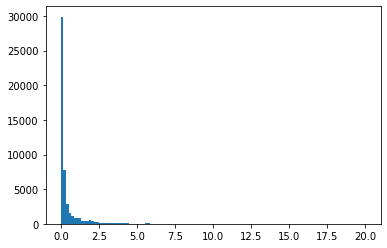

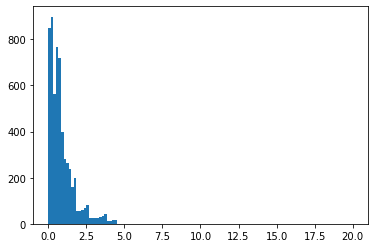

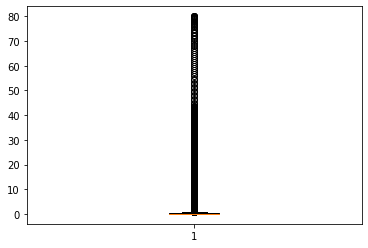

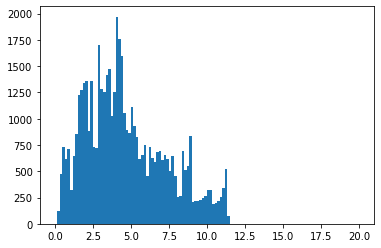

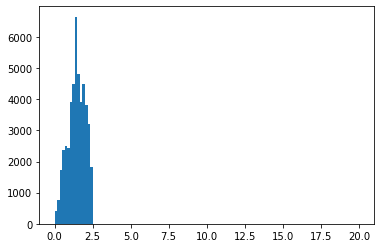

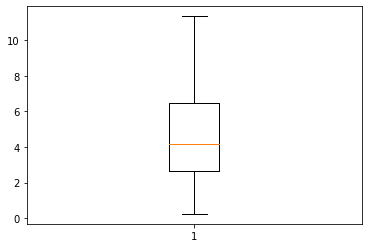

7.9259316589119635
11.199921294462108


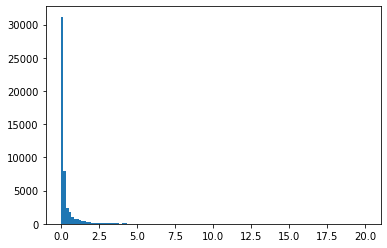

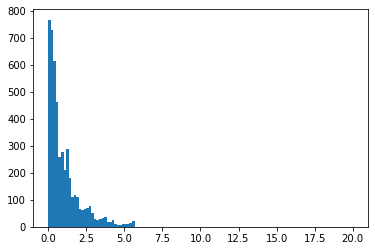

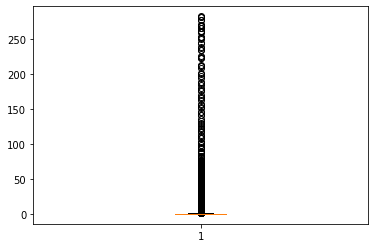

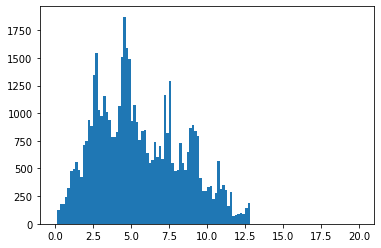

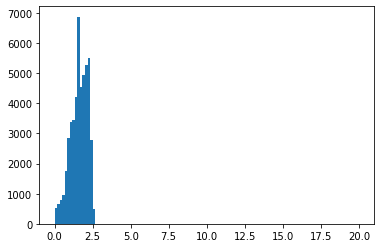

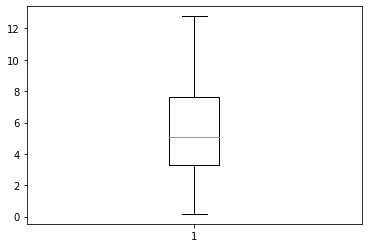

12.299098365664952
12.184480755733134


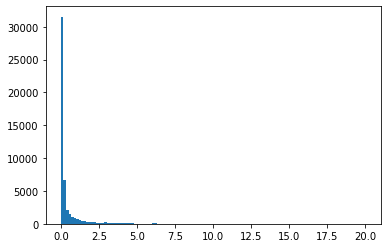

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


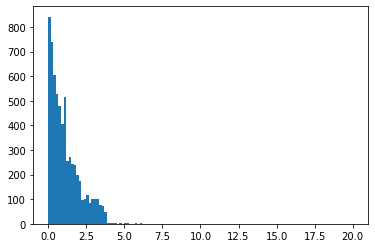

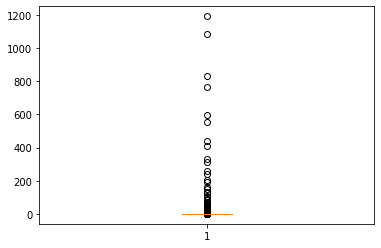

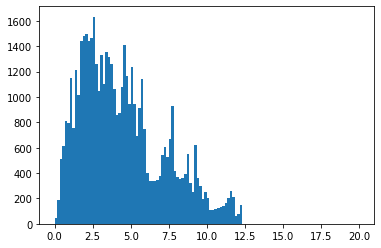

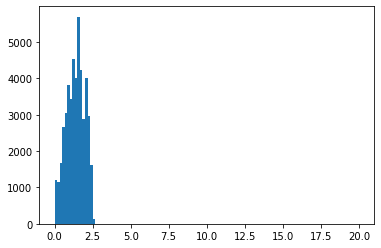

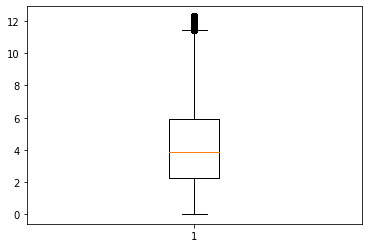

17.931340526034884
11.65412230649326


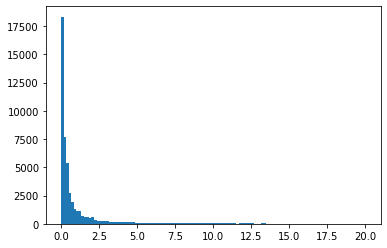

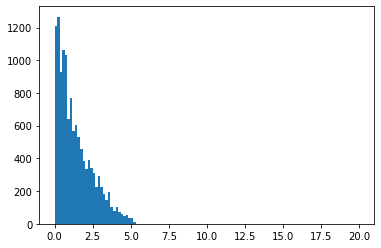

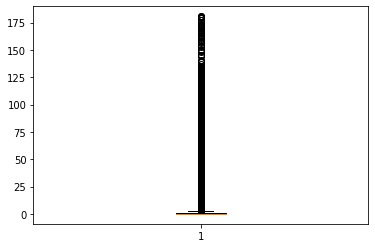

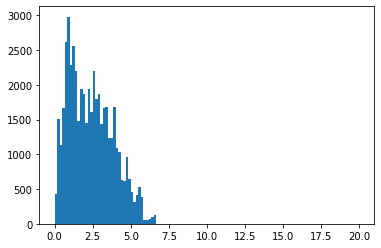

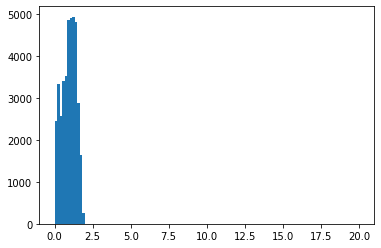

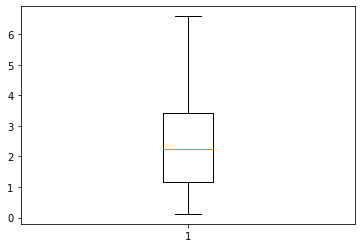

45.46363725685871
5.772531476493636


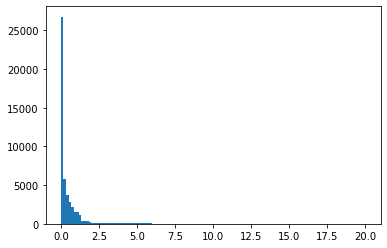

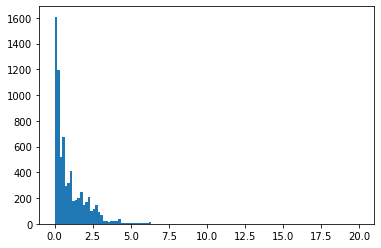

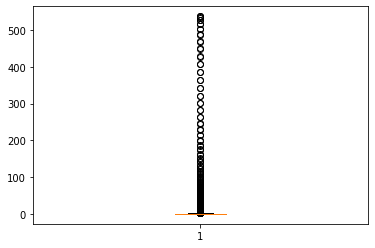

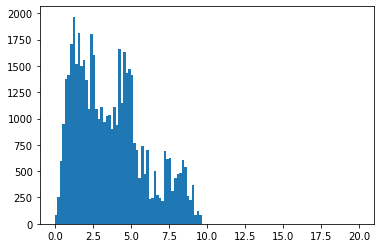

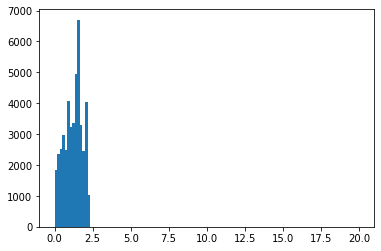

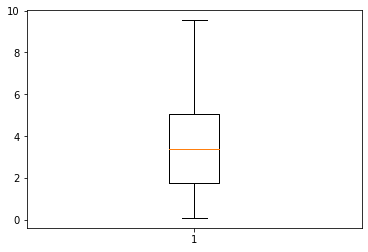

14.81517405606586
9.09458321468161


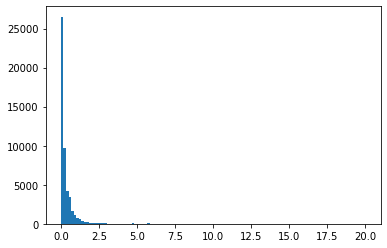

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


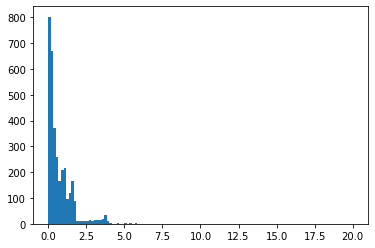

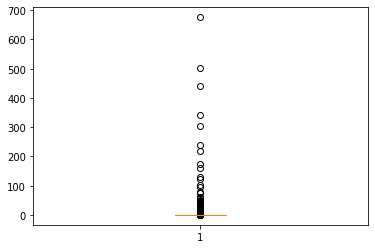

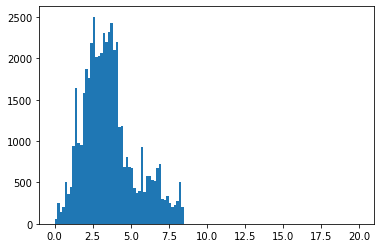

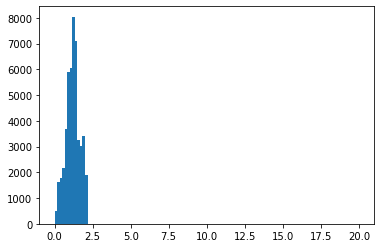

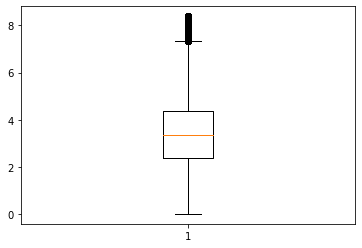

4.2500003289655375
8.260362717825755


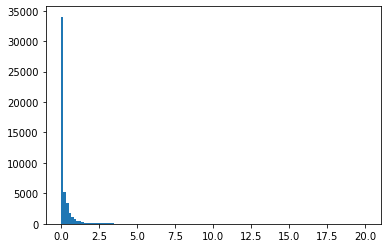

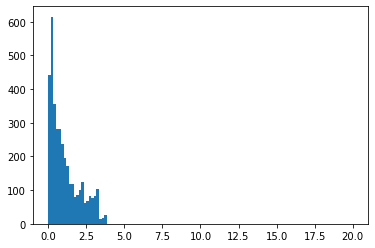

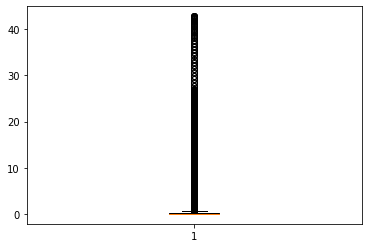

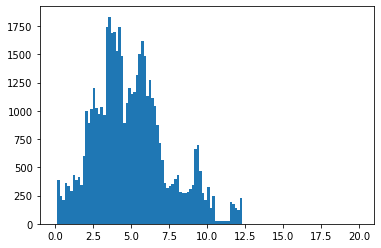

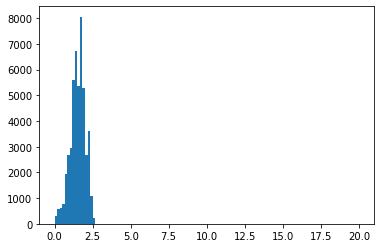

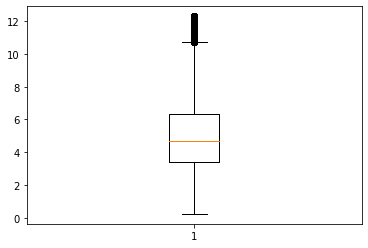

11.343190785263747
11.82726187525401


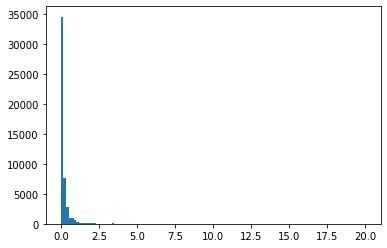

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


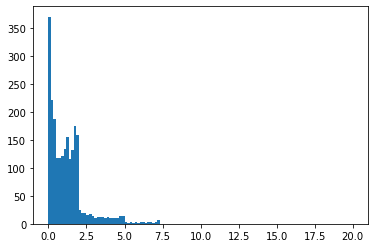

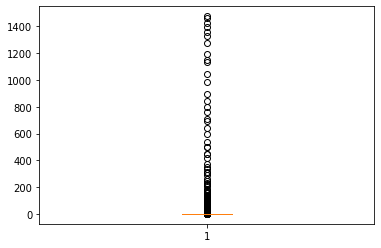

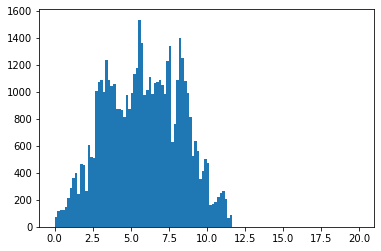

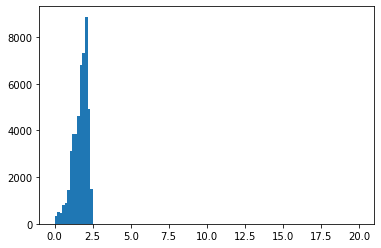

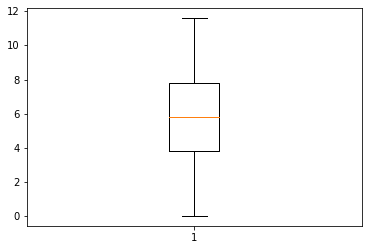

6.1198748936650516
11.093313120451006


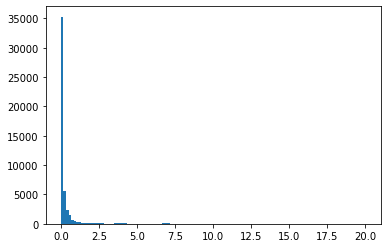

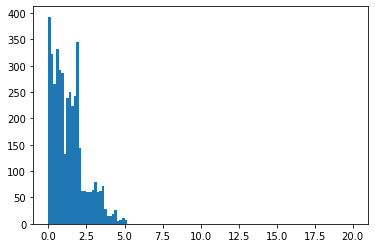

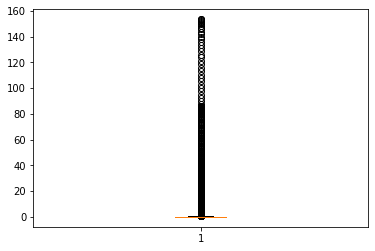

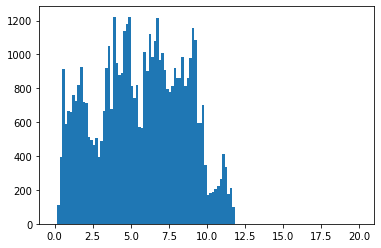

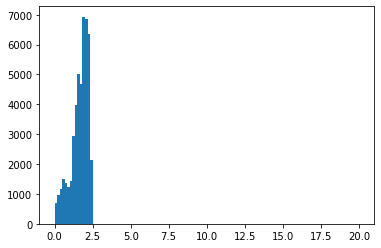

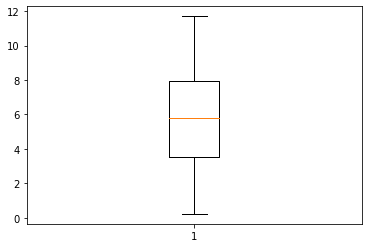

15.755971562543213
11.31783909225936


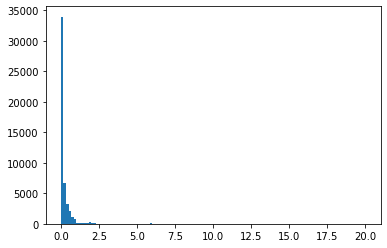

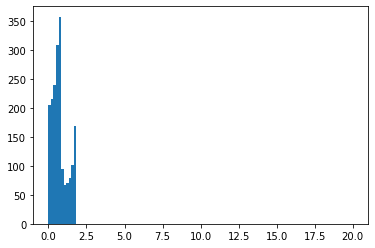

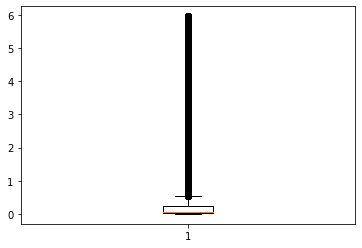

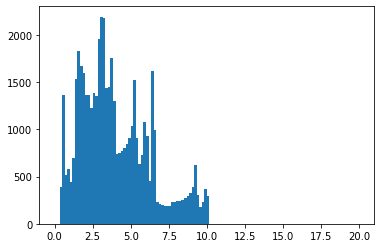

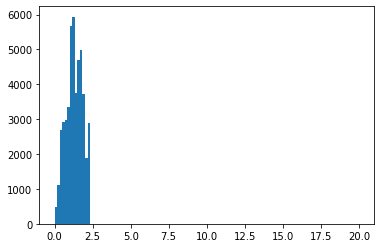

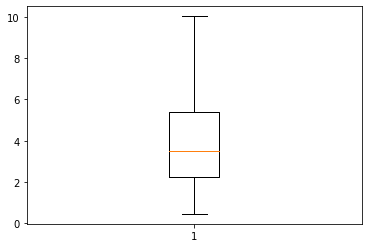

2.6172459442748077
9.923878561375535


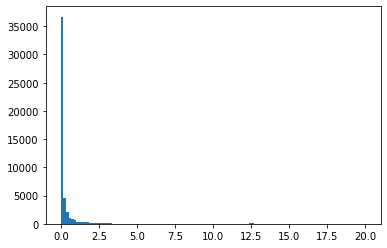

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


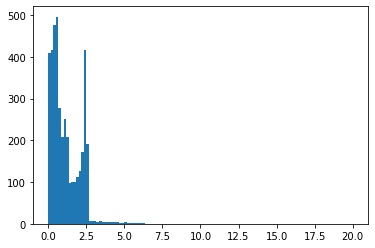

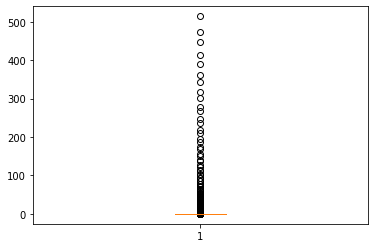

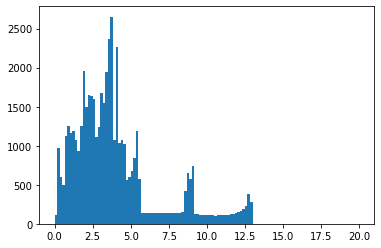

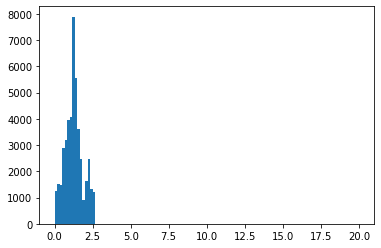

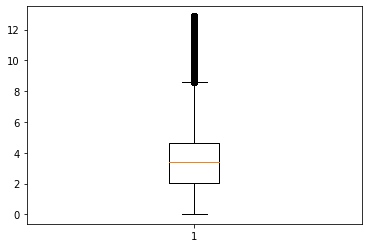

11.335268304092931
12.74981681349044


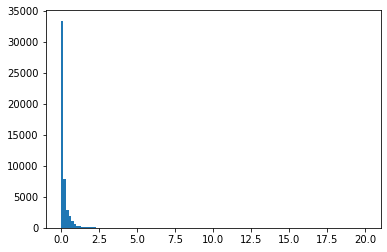

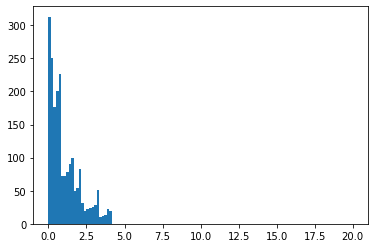

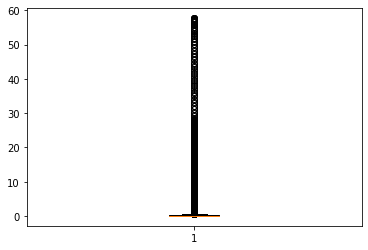

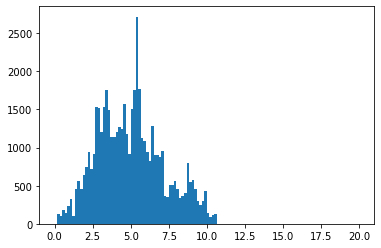

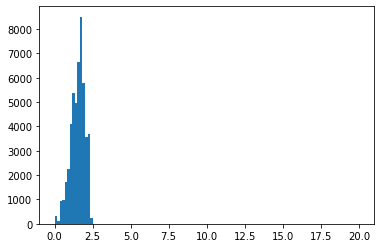

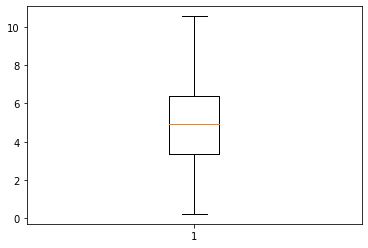

4.830606909557861
9.986838761709535


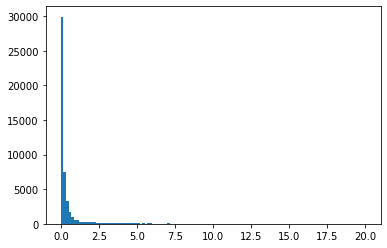

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


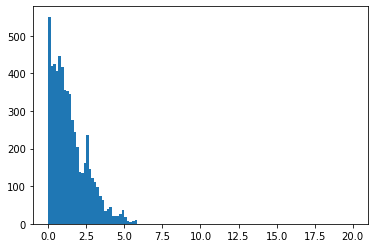

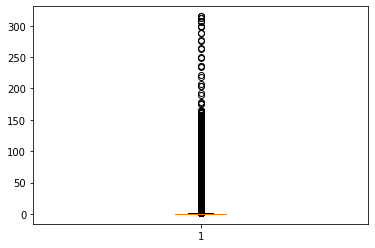

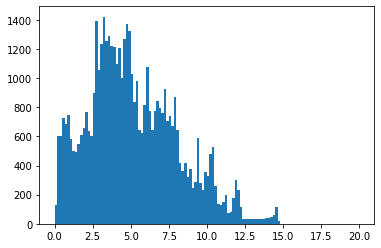

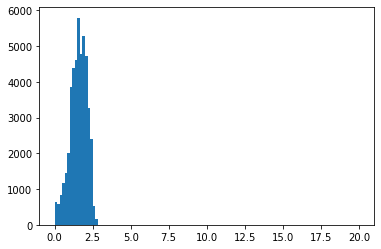

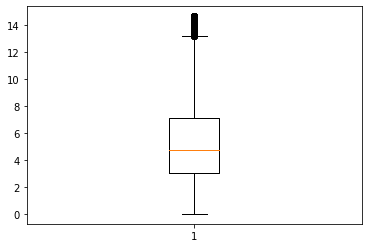

24.88089391752706
12.876793735379636


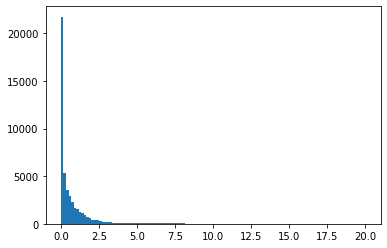

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


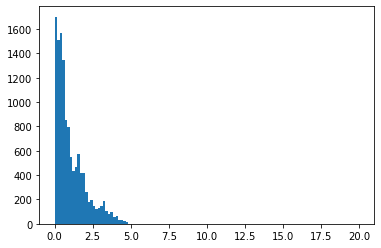

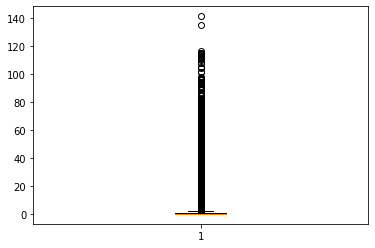

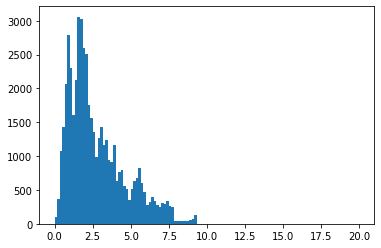

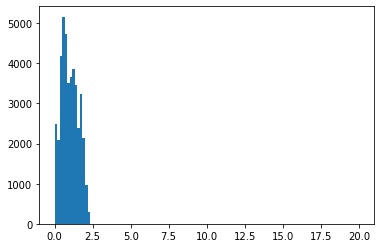

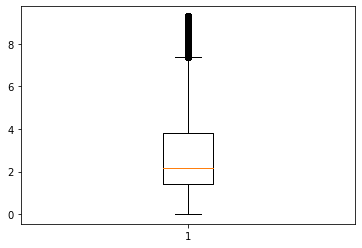

27.65118321077802
7.830470315756653


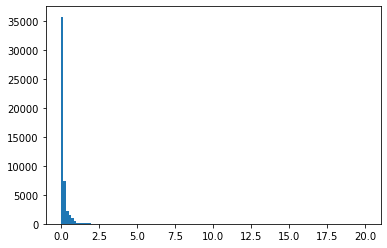

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


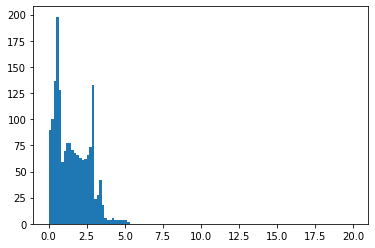

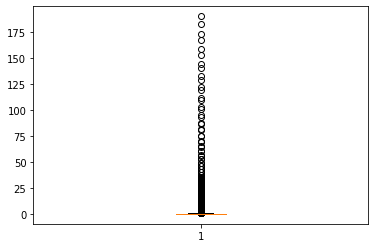

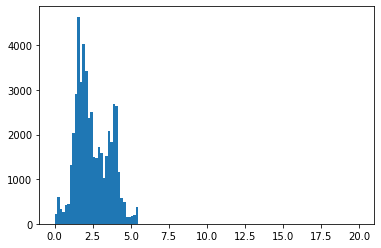

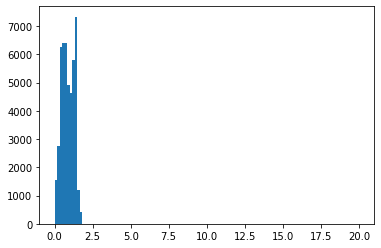

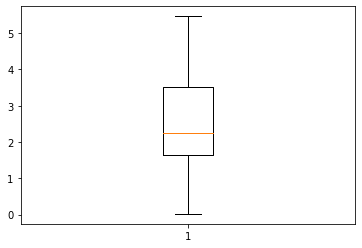

9.977134820286508
5.237571031873948


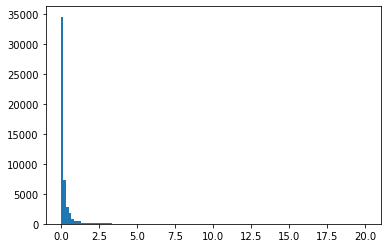

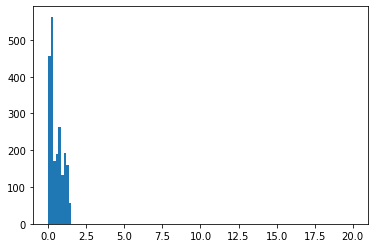

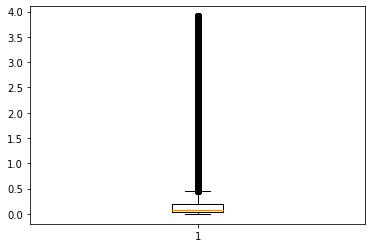

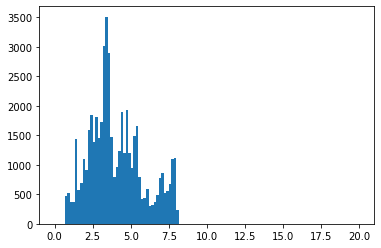

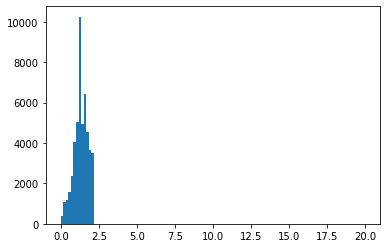

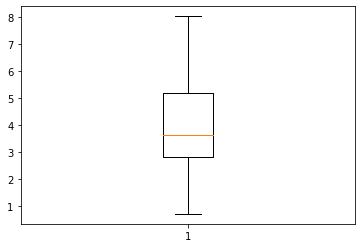

2.4239051212507583
7.933498987361352


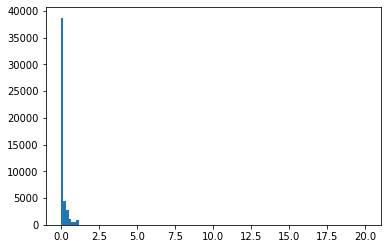

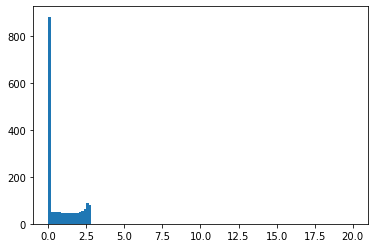

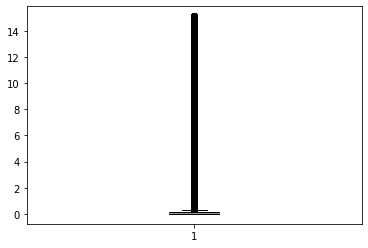

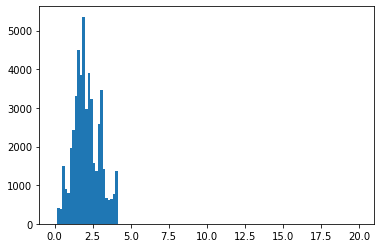

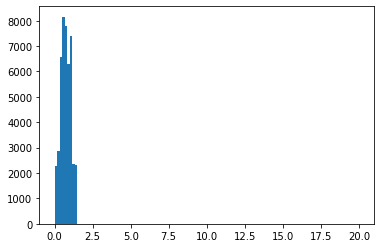

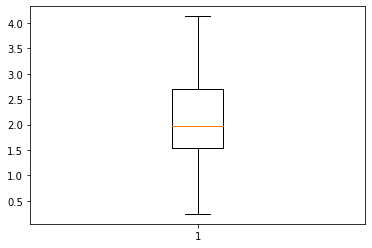

4.086454439742586
4.112143846349008


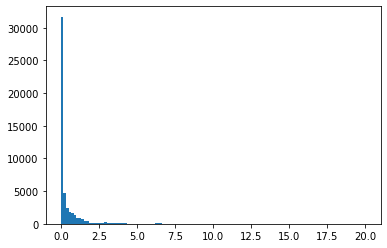

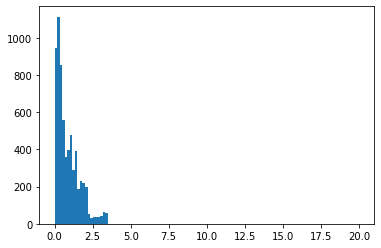

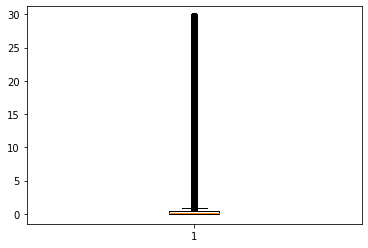

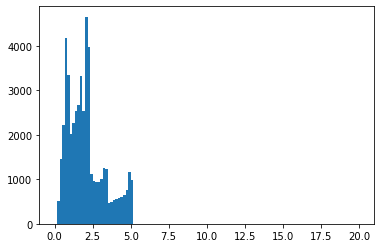

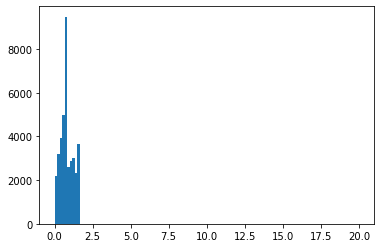

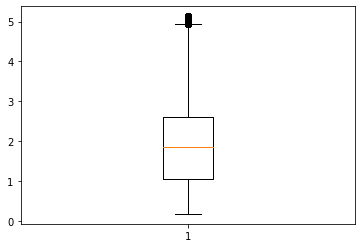

7.8576581808130115
5.098355009449753


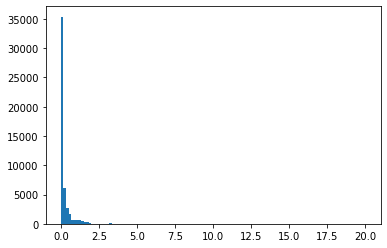

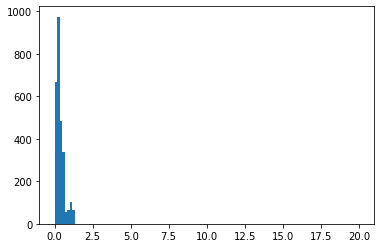

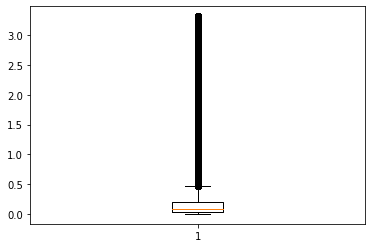

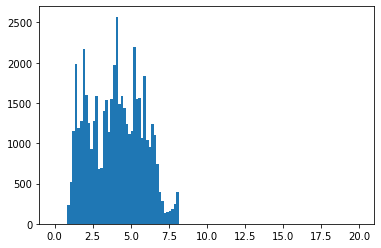

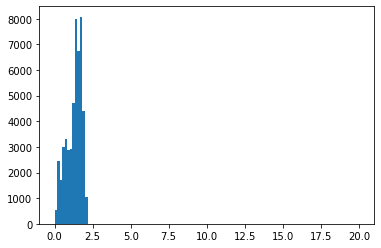

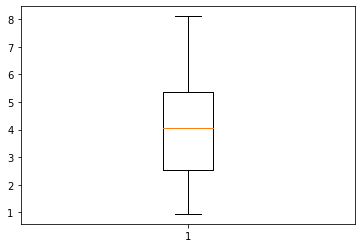

1.708426654077996
7.933441985101014


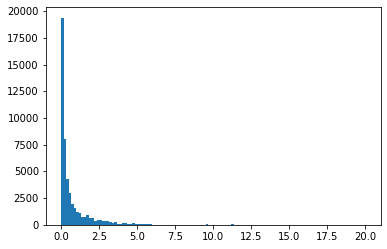

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


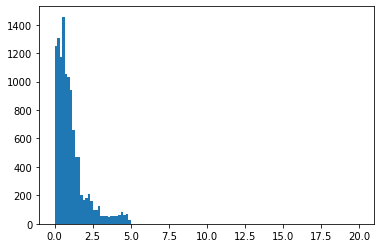

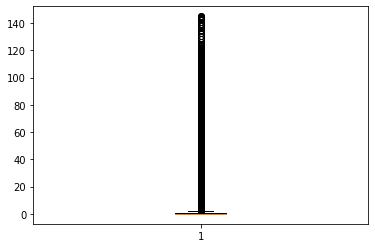

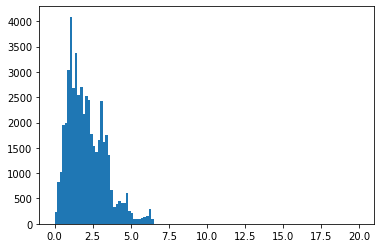

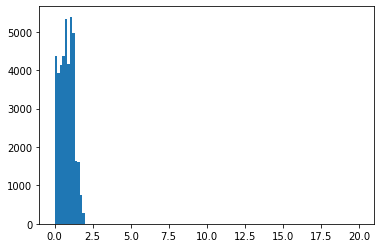

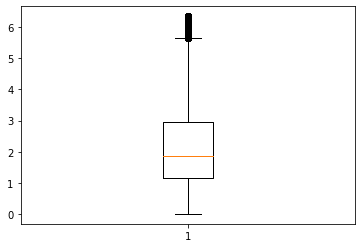

34.85741430622331
6.055523491182575


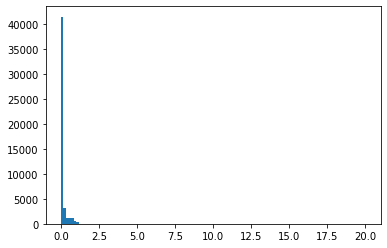

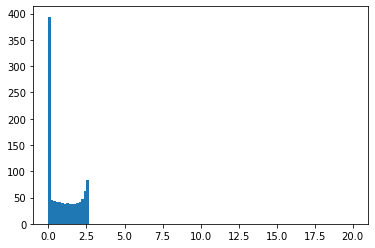

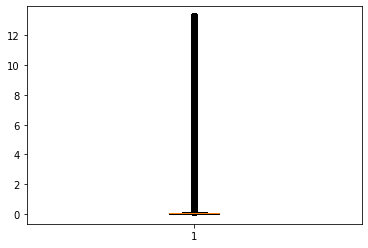

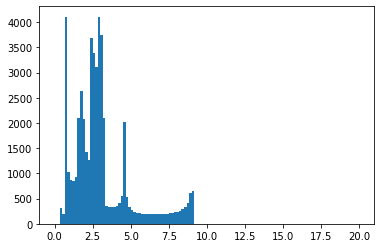

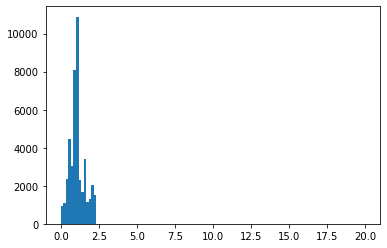

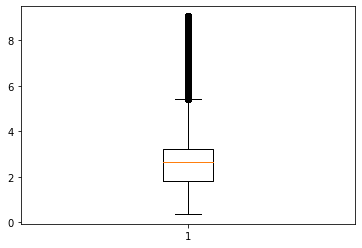

2.3171152695847503
9.025859457794336


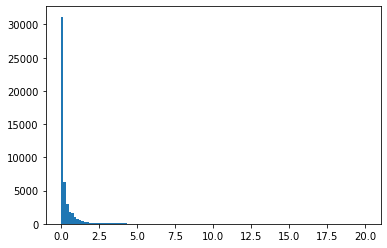

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


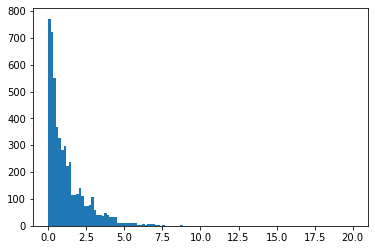

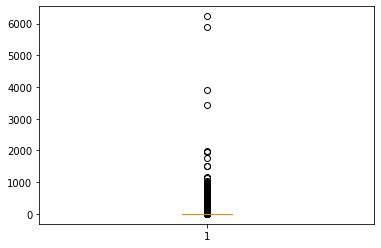

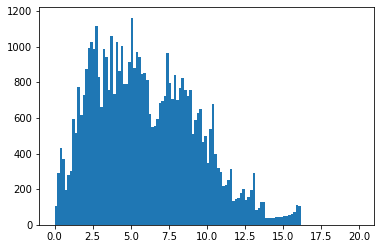

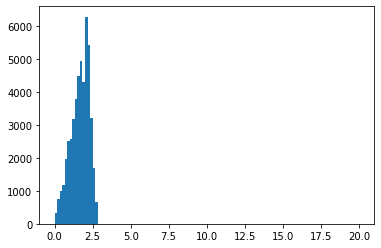

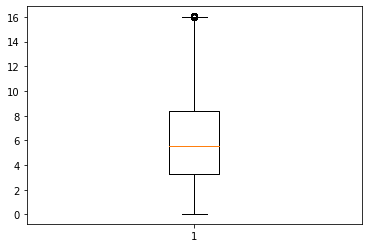

19.31313467933174
15.016303162956913


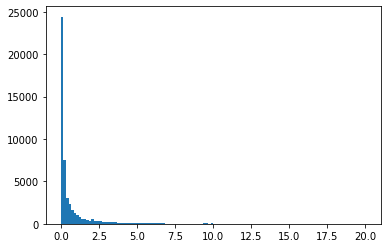

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


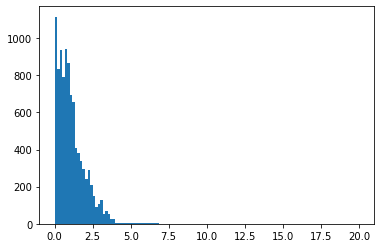

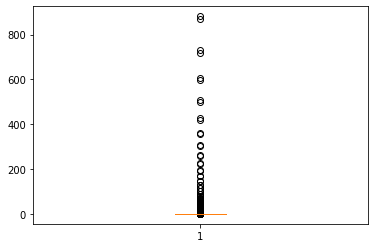

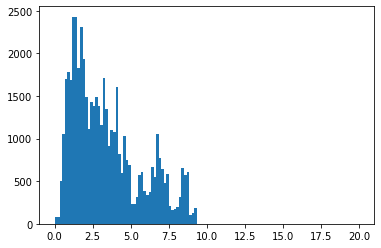

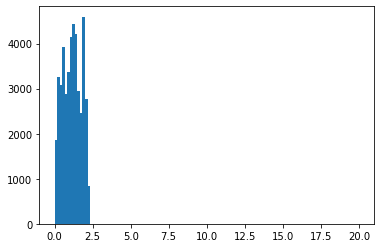

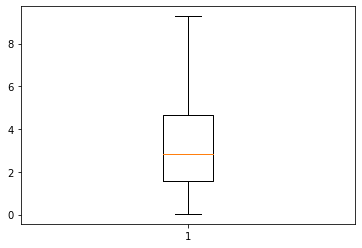

17.036761847839763
8.810157948629056


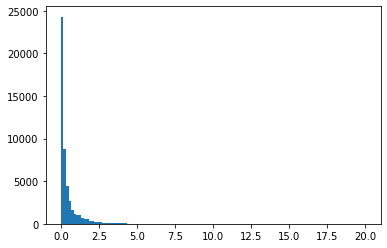

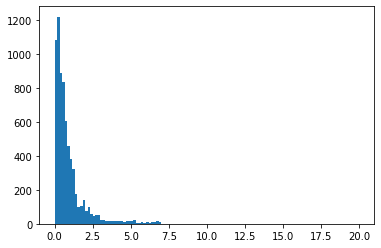

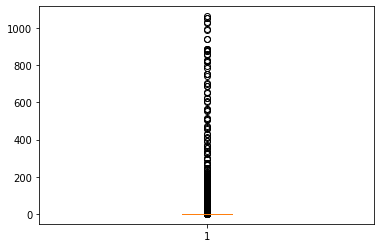

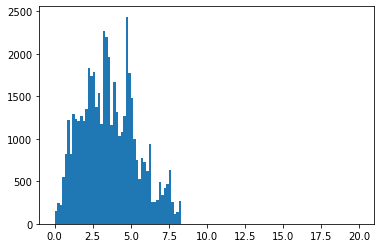

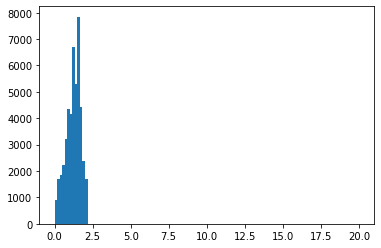

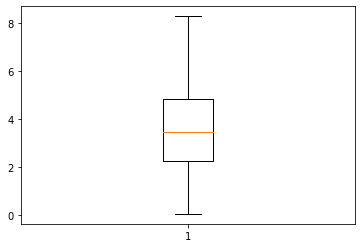

10.380891769706068
7.834345844111306


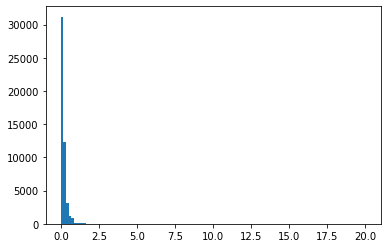

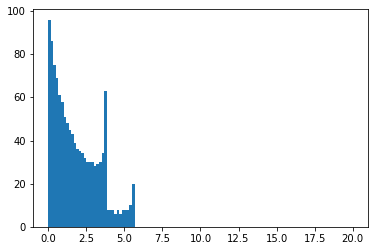

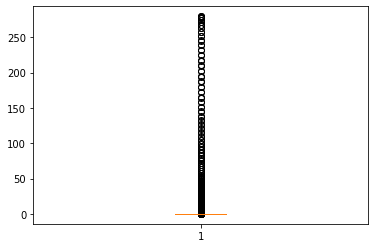

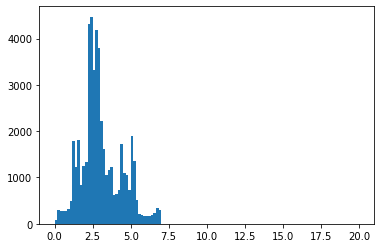

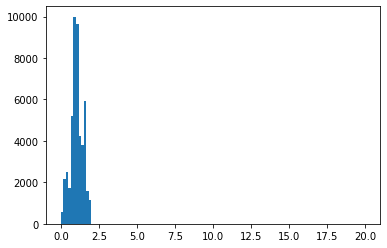

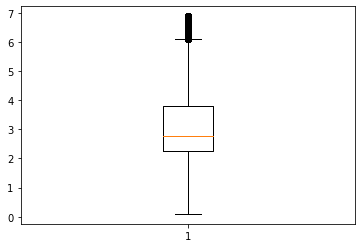

6.517719925758387
6.749900406069901


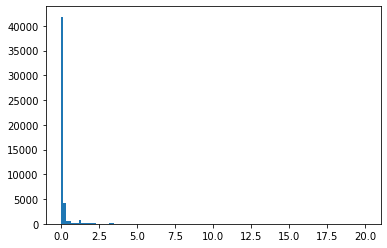

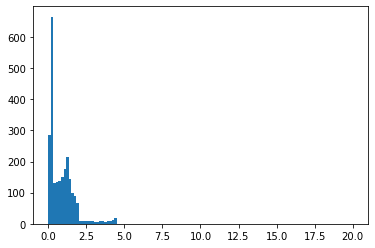

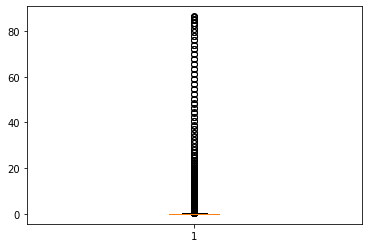

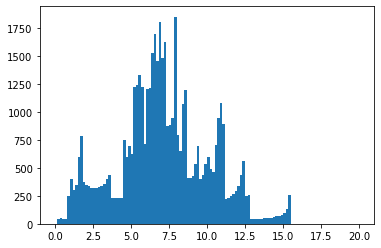

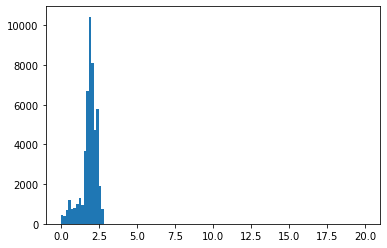

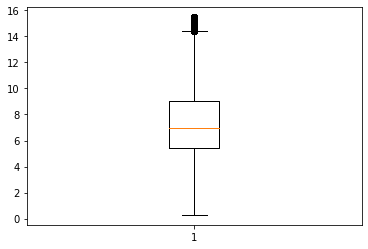

3.9037896420178235
14.978238613583496


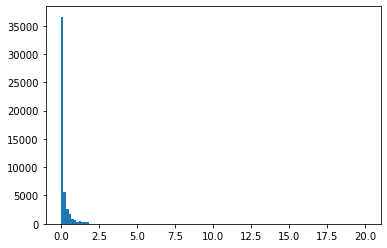

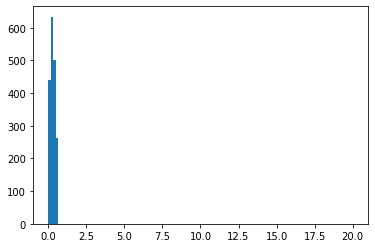

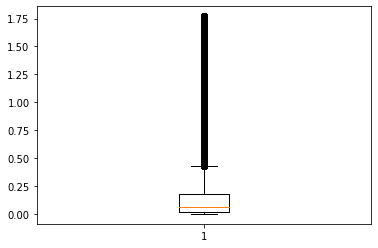

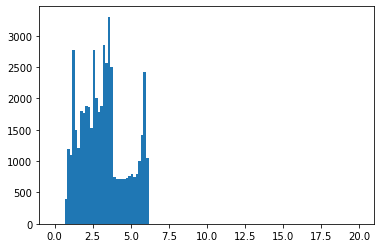

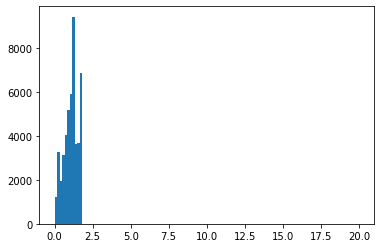

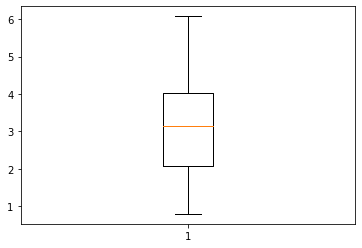

1.5553155550340332
6.060337069744896


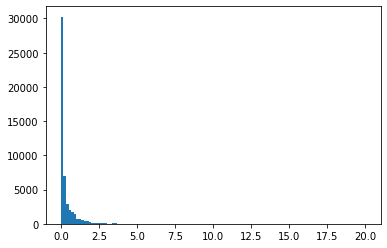

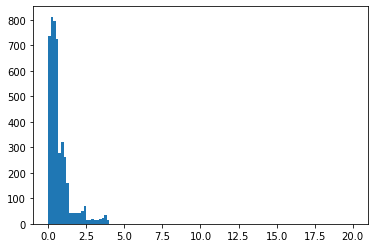

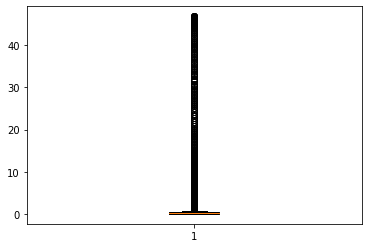

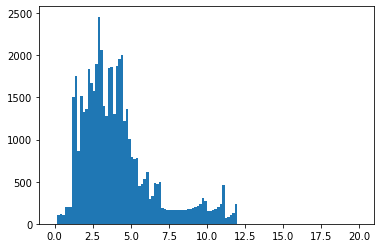

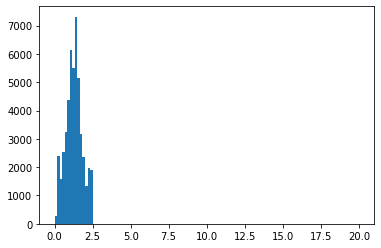

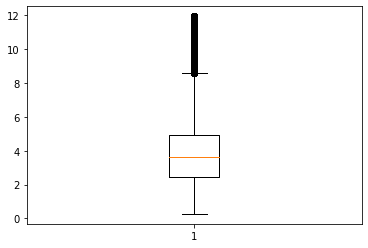

3.8129100156245306
11.4462240368478


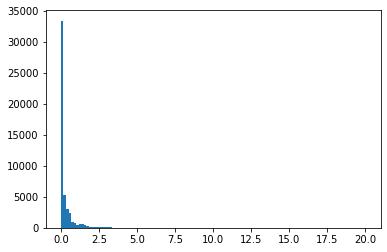

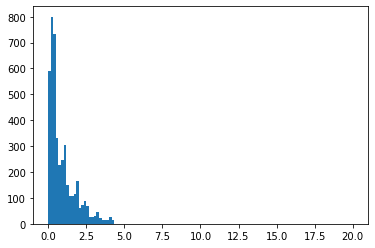

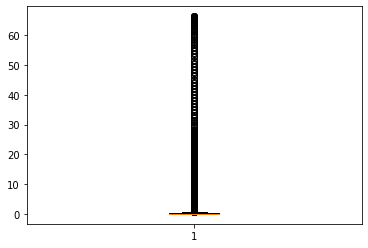

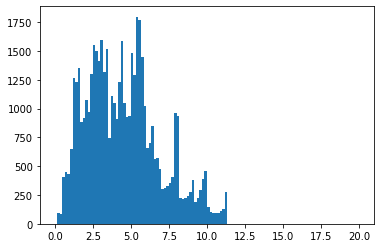

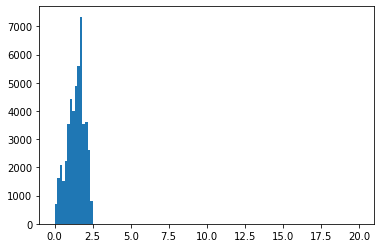

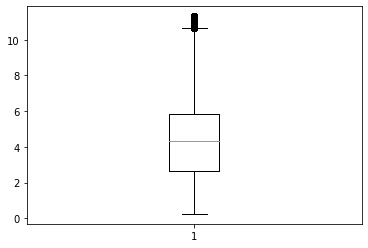

7.754161664432631
10.855633506704603


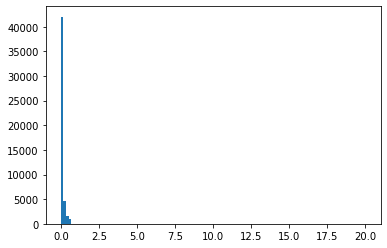

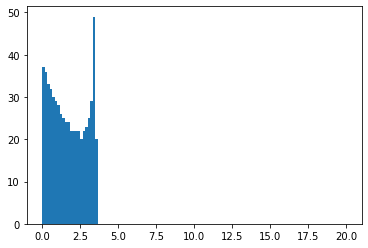

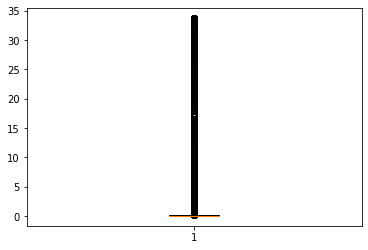

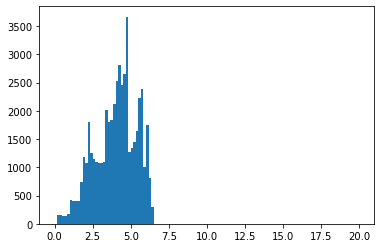

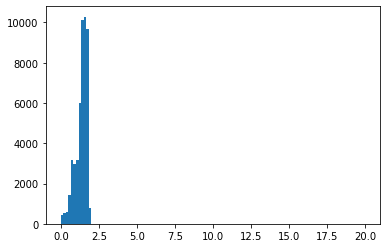

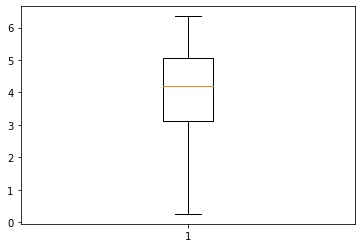

1.595764035529717
6.309600292330472


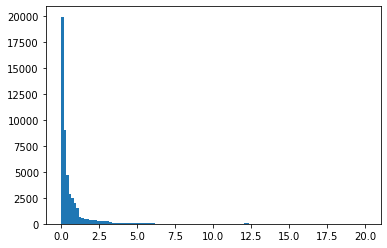

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


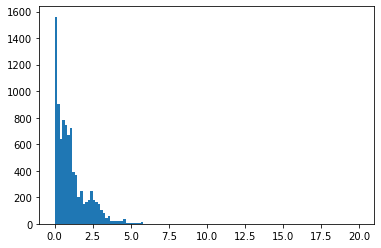

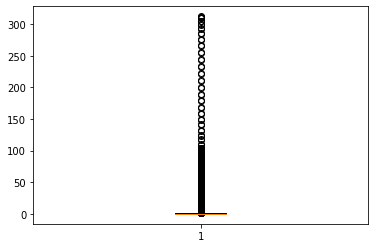

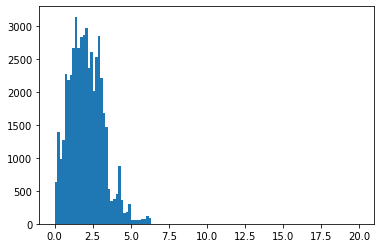

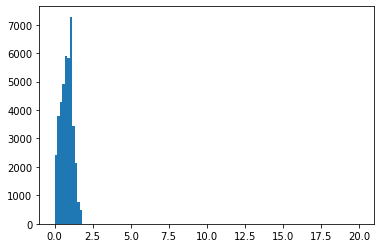

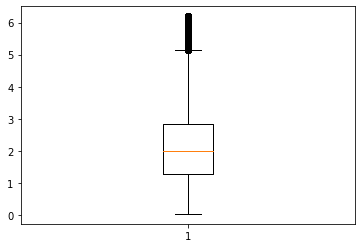

19.555951548771375
5.280239459634558


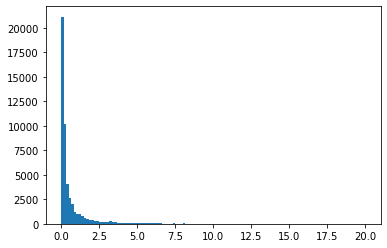

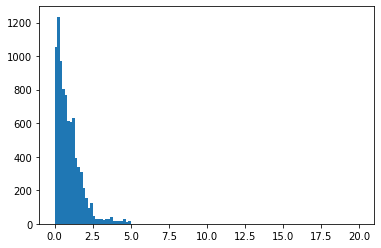

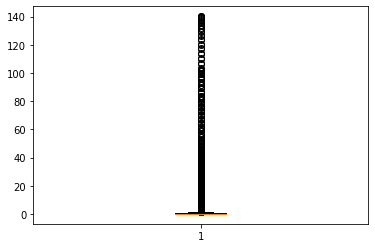

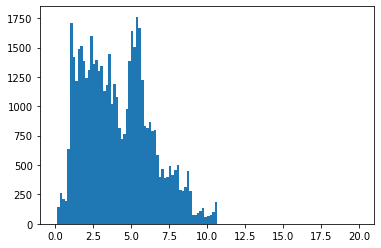

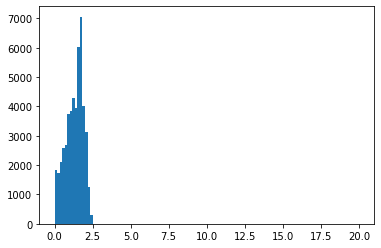

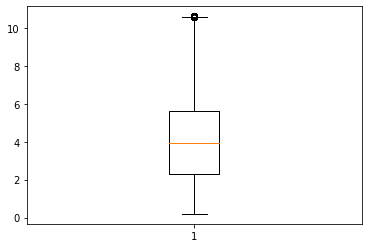

10.221616355265995
9.757568357667605


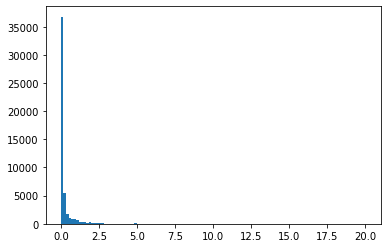

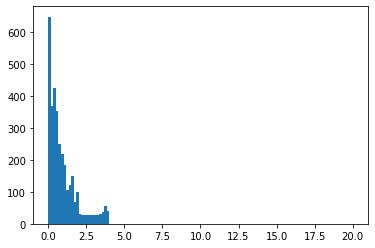

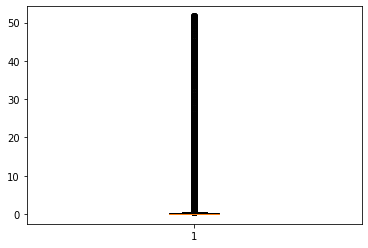

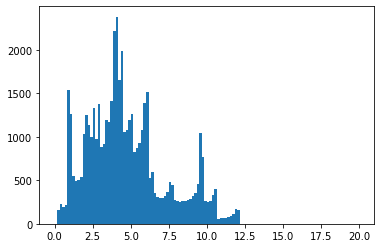

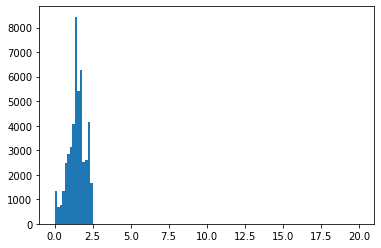

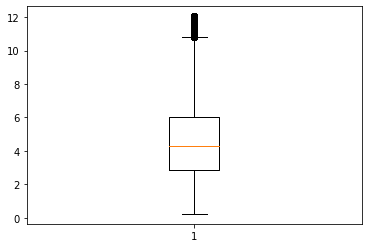

6.0318619778243905
11.57663572975679


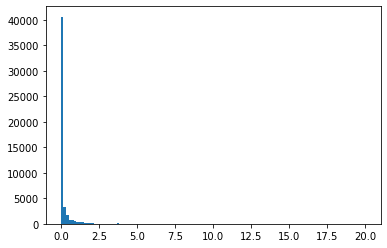

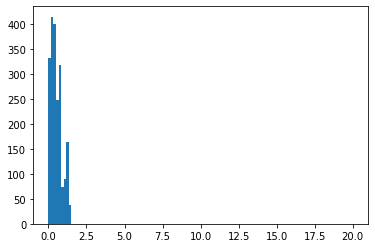

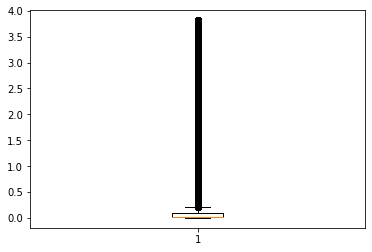

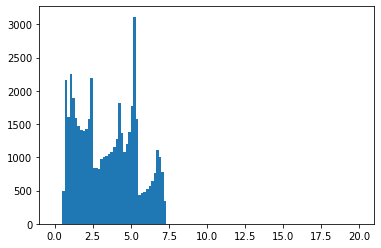

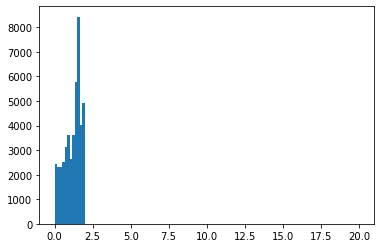

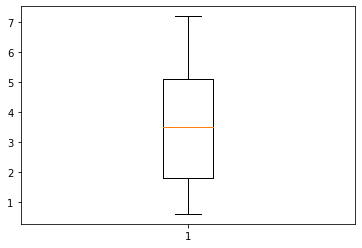

2.09726398935799
7.148239137274204


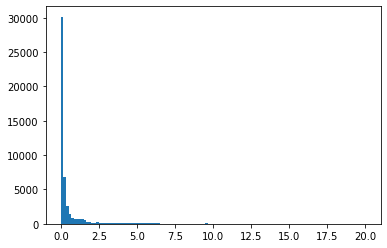

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


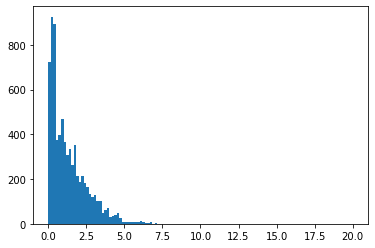

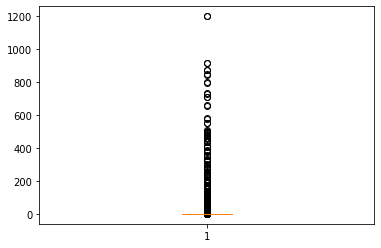

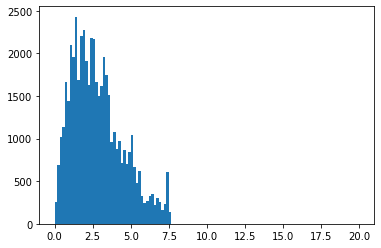

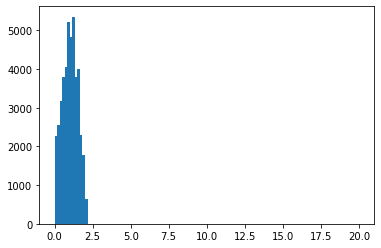

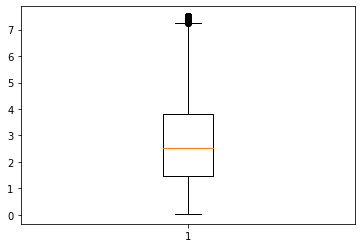

30.861371111644125
7.43688264290687


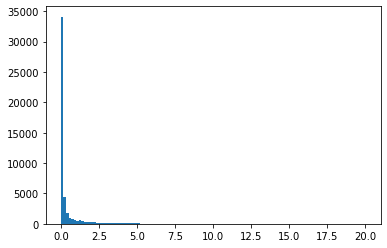

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


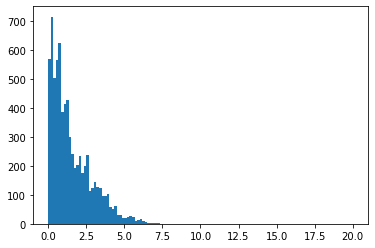

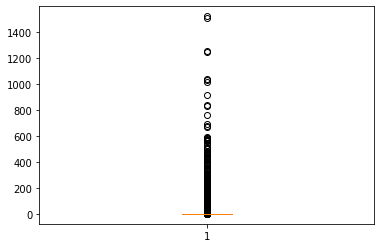

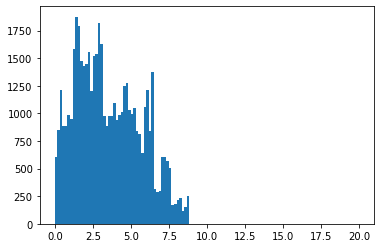

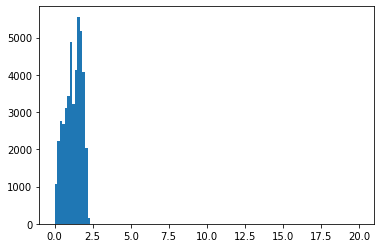

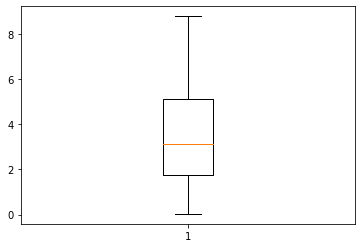

47.53171964163964
8.359916389792353


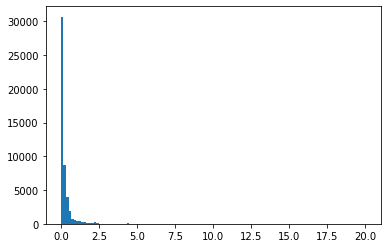

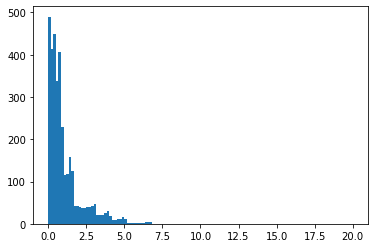

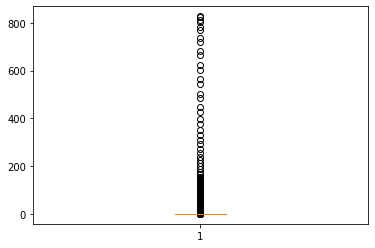

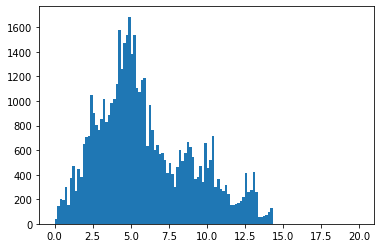

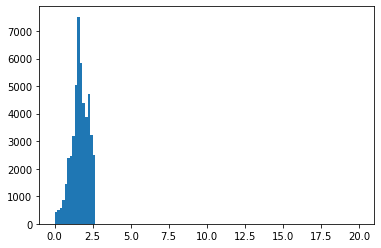

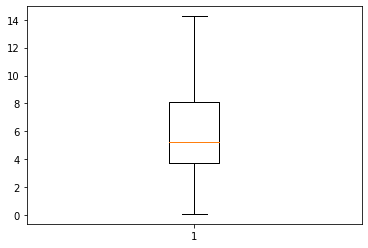

8.040580366303509
13.258404694962744


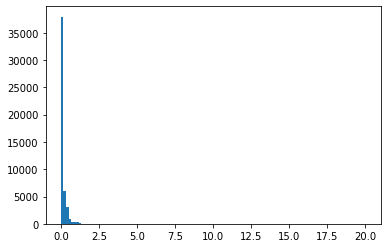

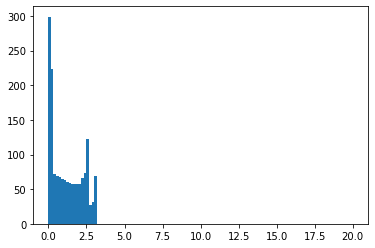

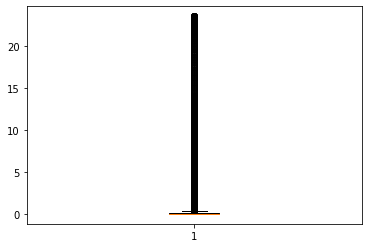

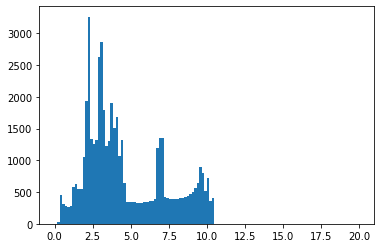

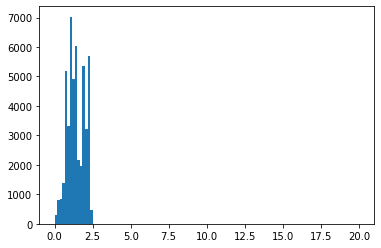

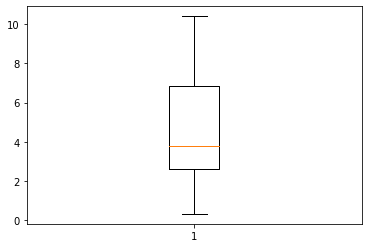

6.3475976916073265
10.298259080116262


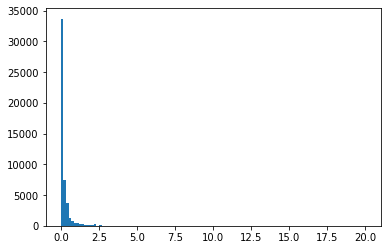

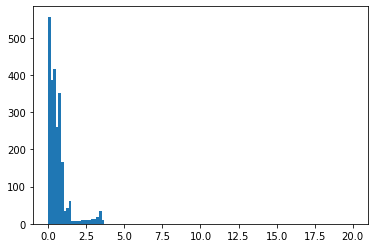

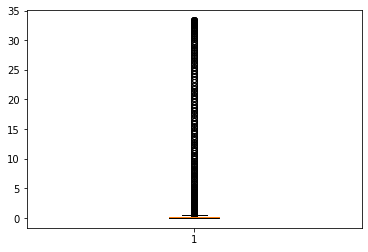

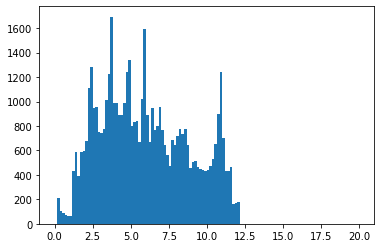

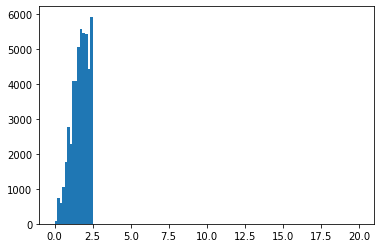

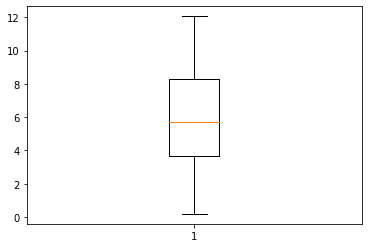

2.2779561653102234
11.668666293243648


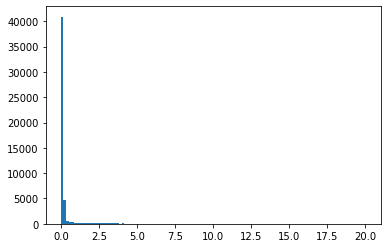

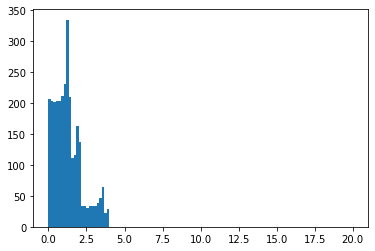

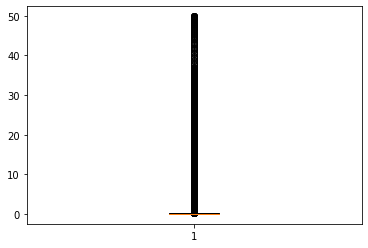

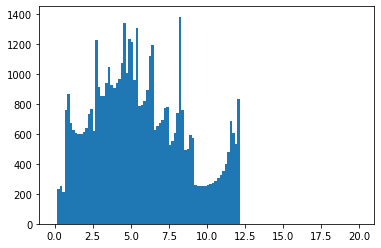

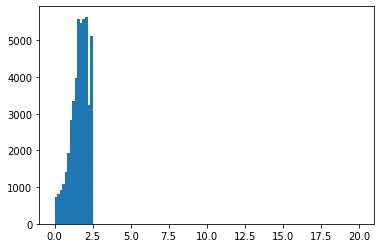

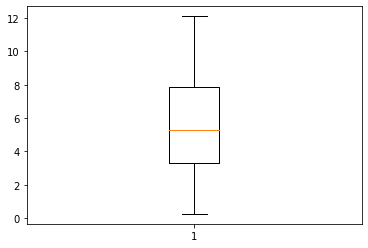

7.5858452408821915
12.065490603854554


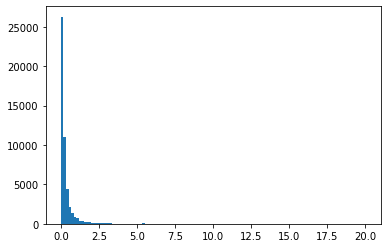

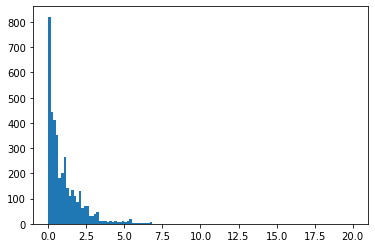

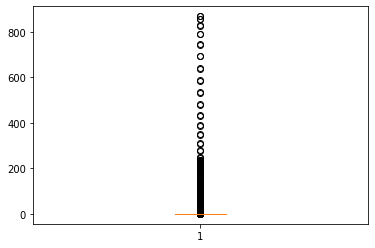

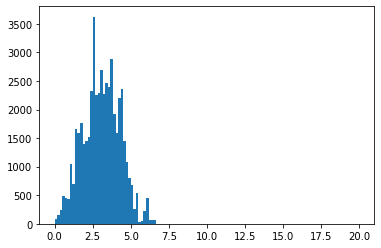

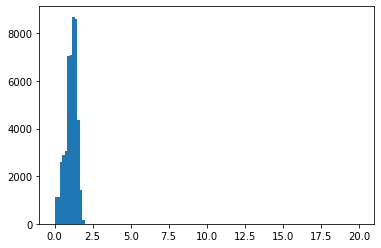

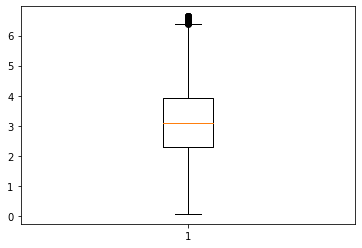

9.223051978440578
6.068422512372608


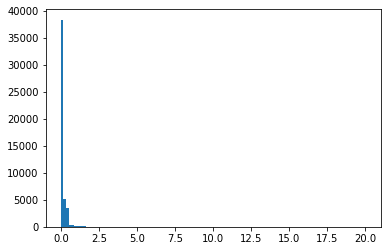

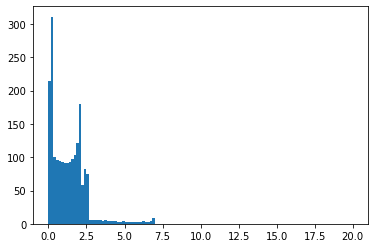

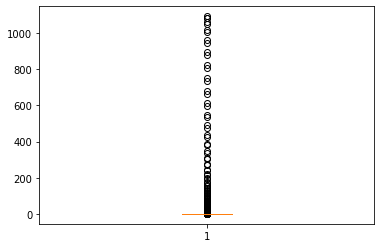

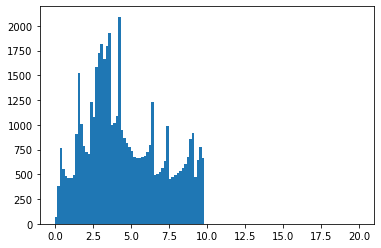

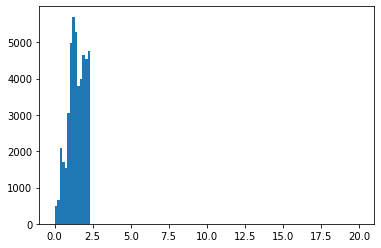

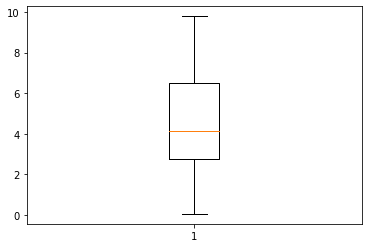

7.409914879803587
9.718073793190039


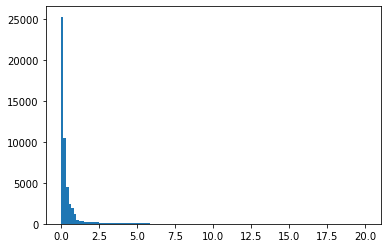

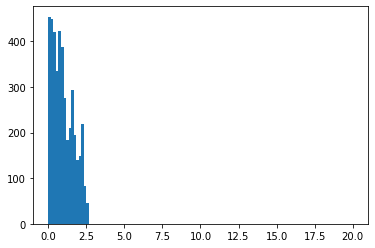

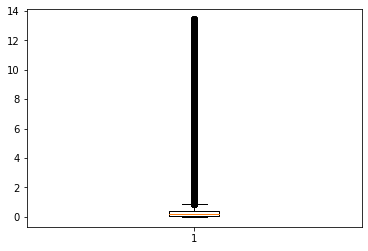

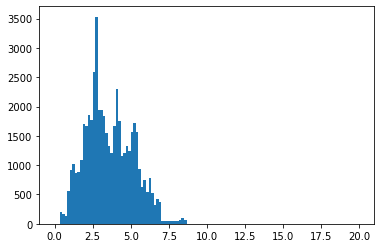

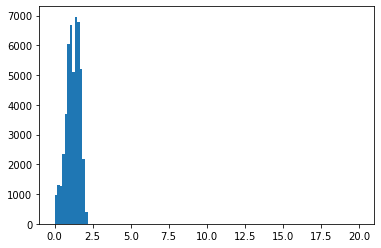

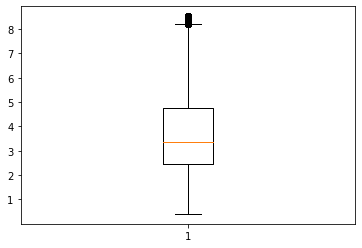

7.310722160634314
7.0620169590359545


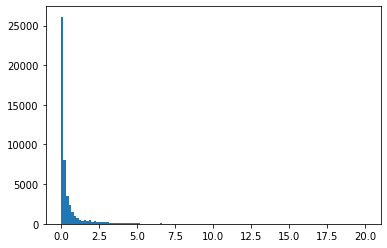

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


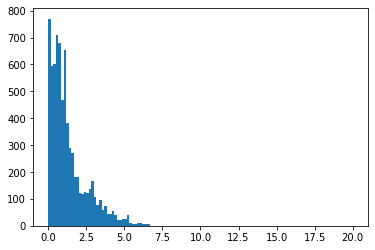

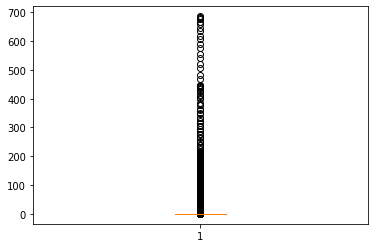

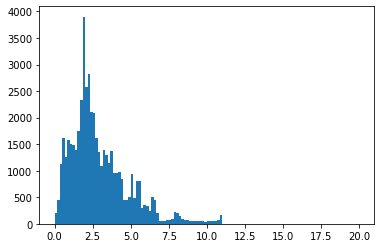

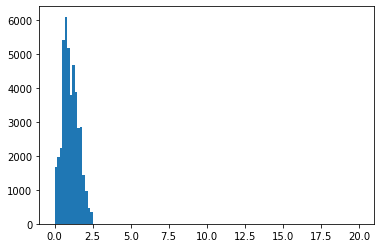

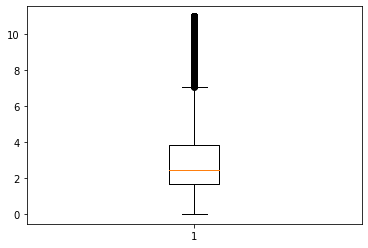

34.379711069861145
9.760952698453833


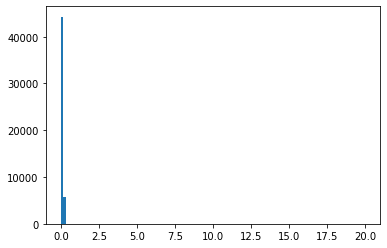

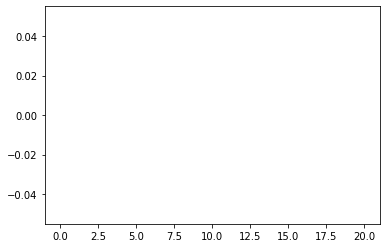

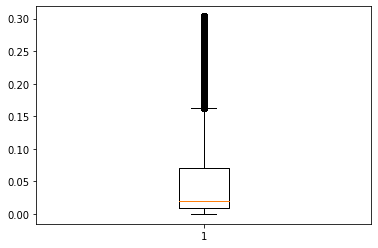

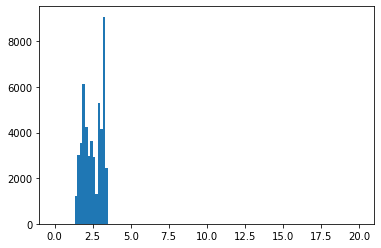

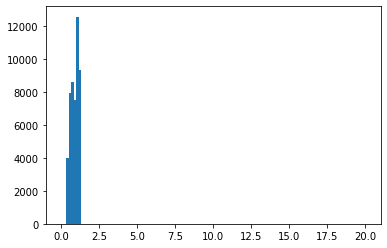

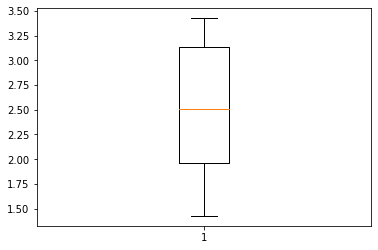

0.29388174497595304
3.4206597494616267


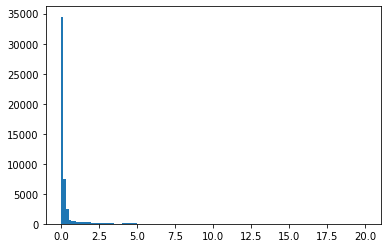

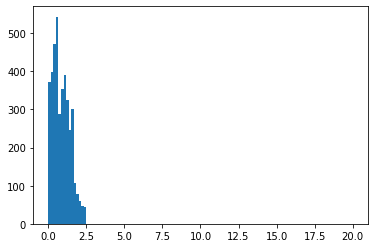

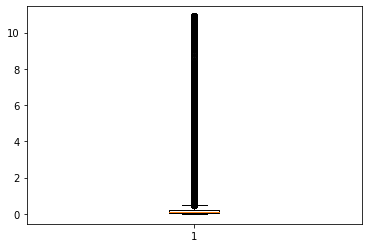

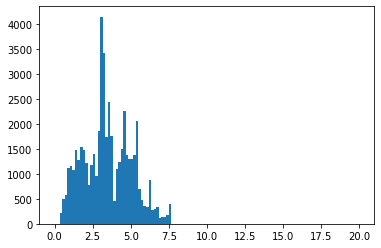

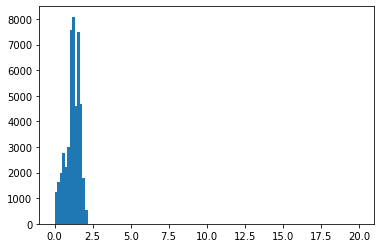

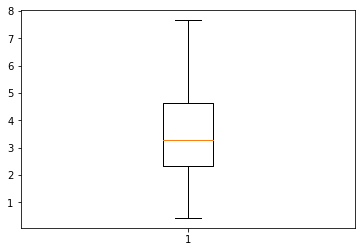

4.811567897406027
7.411306730695713


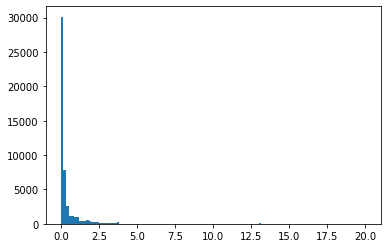

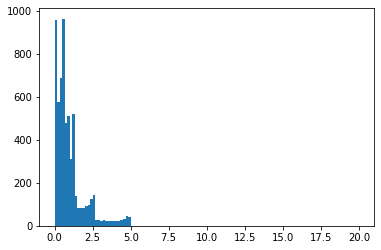

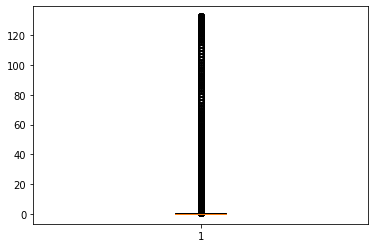

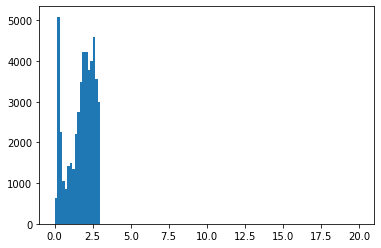

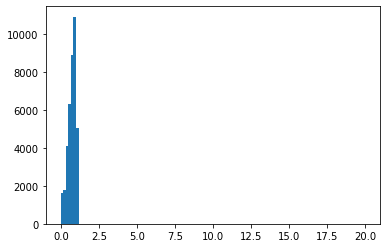

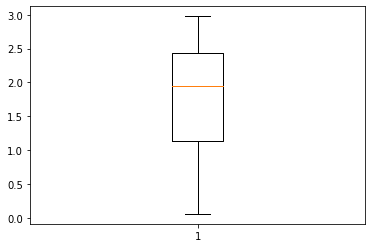

12.497699301116052
2.9687874288628775


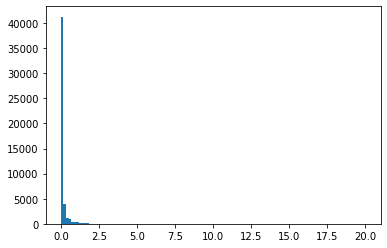

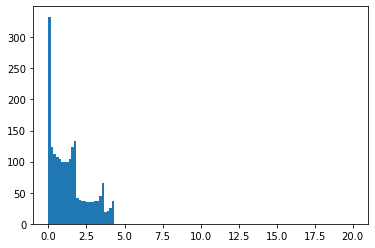

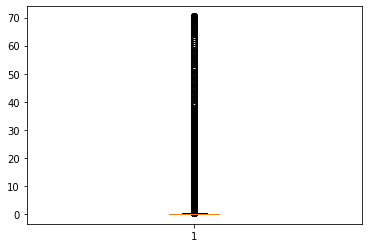

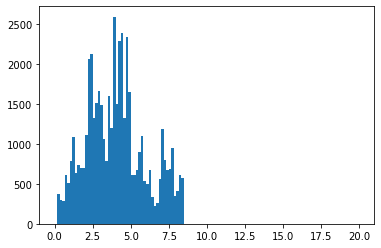

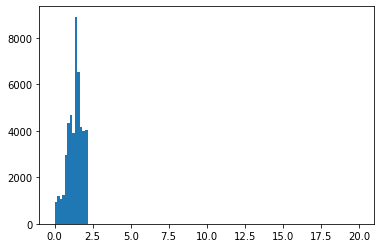

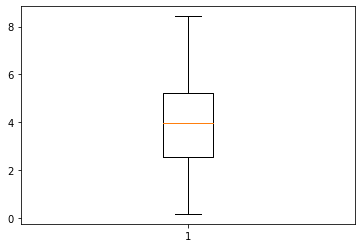

7.371789472974977
8.343065315767657


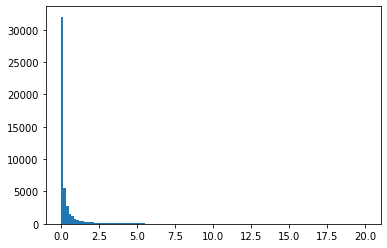

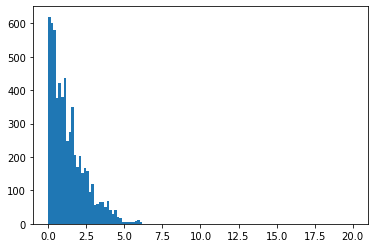

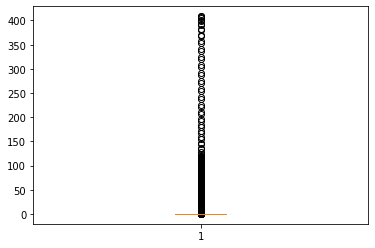

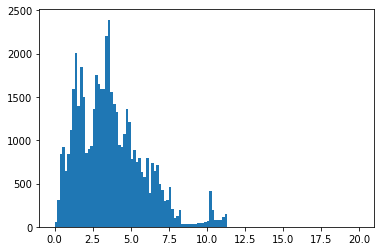

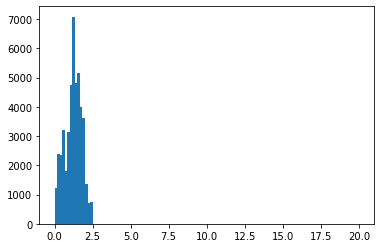

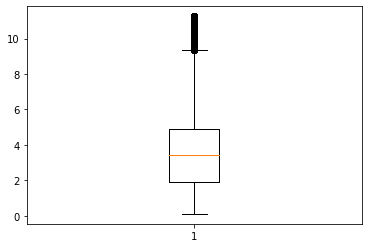

23.47338866632768
10.491572471537335


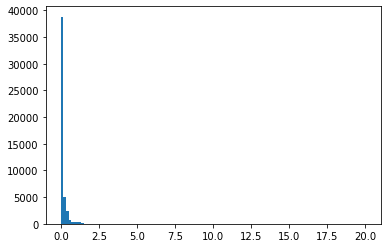

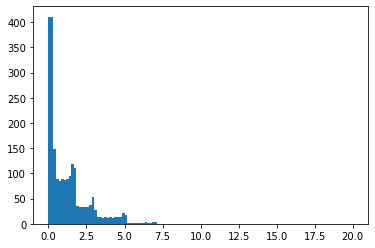

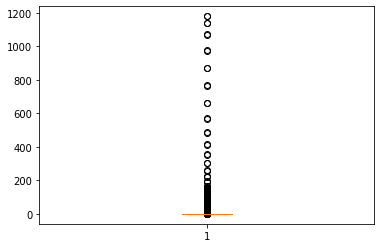

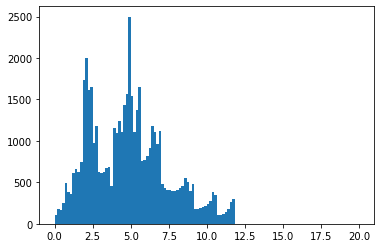

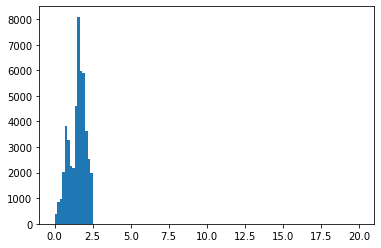

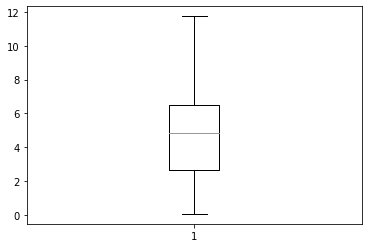

5.927299584113888
11.549375282466134


In [13]:
percentile_99C = []
percentile_99V = []

for i in range(50):
    
    C_array = np.array(C_for_curve[i], dtype=np.float) 
    V_array = np.array(V_for_curve[i], dtype=np.float) 
    
    plt.hist(C_array, bins = 120, range=[0, 20])

    plt.show()
    
    plt.hist(np.log(C_array), bins = 120, range=[0, 20])

    plt.show()
    
    plt.boxplot(C_array)
    
    plt.show()
    
    plt.hist(V_array, bins = 120, range=[0, 20])

    plt.show()
    
    plt.hist(np.log(V_array), bins = 120, range=[0, 20])

    plt.show()
    
    plt.boxplot(V_array)
    
    plt.show()
    
    perC = np.percentile(C_array, 99)
    perV = np.percentile(V_array, 99)
    percentile_99C.append(perC)
    percentile_99V.append(perV)
    print (perC)
    print (perV)
    
#curvature benchmark = 10, so Rmin = 1/10 mm, so pixel density = 5-10 px/mm

In [10]:
for i in range(50):
    
    plt.hist(np.log(C_for_curve[i]+1), bins = 70, range=[0, 20])

    plt.show()
    
    plt.hist(1/(C_for_curve[i]), bins = 70, range=[0, 20])

    plt.show()
    
    plt.boxplot(np.log(C_for_curve[i]+1))
    
    plt.show()
    
    plt.hist(np.log(V_for_curve[i]+1), bins = 70, range=[0, 20])

    plt.show()
    
    plt.boxplot(np.log(V_for_curve[i]+1))
    
    plt.show()

TypeError: can only concatenate list (not "int") to list

In [ ]:
plt.hist(percentile_99C, bins = 30, range=[0, 50])
plt.show()

#so maybe choose curvature/pixel density = 20-30

In [ ]:
plt.hist(percentile_99V, bins = 30, range=[0, 50])
plt.show()

In [ ]:
#percentile_99
#34, 35, 43, 12, 13, 19

In [12]:
max_c = []
max_v = []
for i in range(50):
    max_c.append(max(C_for_curve[i]))
    max_v.append(max(V_for_curve[i]))
max_c

[80.05108988190511,
 282.6381047948847,
 1192.3430357173752,
 180.7790058631567,
 537.6096875391751,
 675.9918977813342,
 42.830224054102615,
 1475.7119037249718,
 153.599729268789,
 5.961063148118167,
 514.1227013450349,
 57.66966913469227,
 315.0975947399504,
 141.28169202695855,
 189.9972939036731,
 3.908844209477621,
 15.124396683173346,
 29.702150134127354,
 3.318316252821498,
 144.94102697477118,
 13.292551198733575,
 6228.934173268035,
 881.735352697215,
 1063.894092163375,
 279.756746185578,
 86.46217908464929,
 1.7704563088422964,
 46.8684273595113,
 66.43325780254528,
 33.68616502396259,
 312.4732201360327,
 140.19991795965862,
 51.67187626041652,
 3.8176932691709076,
 1199.4077454707153,
 1519.1442122173794,
 827.6206128091347,
 23.59626647669985,
 33.357438752263306,
 49.905703495597805,
 867.777092273575,
 1091.8811097400715,
 13.432142962522285,
 686.0329653163664,
 0.3035136890997121,
 10.89800578089153,
 132.78074172417024,
 70.47627453625326,
 408.7815822354391,
 1179.

In [13]:
max_v
#also check curvature stats, sd and mean for each curve with outliers removed (to see if it's above 1)
#same for velocity

[11.338473275164844,
 12.780929350609942,
 12.297623882886102,
 6.585544345233806,
 9.534645569453298,
 8.386855424883061,
 12.296135150442977,
 11.586038239299187,
 11.706679205243148,
 10.042112903108883,
 12.869261037020133,
 10.563724841432848,
 14.671239285045763,
 9.300039399499736,
 5.465367402128545,
 8.03322839261033,
 4.13016435562771,
 5.133009898604974,
 8.107902701533153,
 6.346354676199619,
 9.06236756814197,
 16.056980638543987,
 9.275253108530569,
 8.281549801936839,
 6.882697317529718,
 15.470068771871043,
 6.078250634633017,
 11.952801779428418,
 11.315118426212859,
 6.346757371175803,
 6.1977834499984334,
 10.617491617056231,
 12.049807252886856,
 7.184319460435323,
 7.504751406923498,
 8.796091645537883,
 14.245833446377352,
 10.399345404327754,
 12.060847059662146,
 12.103504239747119,
 6.64322655082526,
 9.788218074043792,
 8.530887963402375,
 10.9789390259728,
 3.4244515250619534,
 7.66518706388234,
 2.976751259609931,
 8.431550697893574,
 11.261058309472809,
 11

In [20]:
def norm(data):
    """
    Given data, find the mean and standard deviation.
    :Parameters:
     data : list of data values
    :Returns:
     mean, stds
    """
    #remove outliers <1.5 IQR from calculation
    data = np.array(data, dtype=np.float)
    
    Q1,Q3 = np.percentile(data, [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    data_array_no_high_outliers = data[data < upper_range]
    data_array_no_outliers = data_array_no_high_outliers[data_array_no_high_outliers > lower_range]
    
    mean = np.mean(data_array_no_outliers)
    std = np.std(data_array_no_outliers)
    return mean, std

In [21]:
for i in range(50):
    
    dataC = C_for_curve[i]
    dataV = V_for_curve[i]
    
    C_mean, C_sd = norm(dataC)
    V_mean, V_sd = norm(dataV)
    
    print("for curve no."+str(i)+ ": curvature mean =" + str(C_mean)+ ", curvature sd =" + str(C_sd) + 
          ", velocity mean = " + str(V_mean) + ", velocity sd = " + str(V_sd))

for curve no.0: curvature mean =0.13809825478309587, curvature sd =0.1626224748241053, velocity mean = 4.683577397471966, velocity sd = 2.6716771956112826
for curve no.1: curvature mean =0.12968818915342387, curvature sd =0.12868852144836174, velocity mean = 5.585369983211143, velocity sd = 2.830324204862679
for curve no.2: curvature mean =0.12213924551140878, curvature sd =0.1455056136492661, velocity mean = 4.321215548215651, velocity sd = 2.593459591331819
for curve no.3: curvature mean =0.4285755495668796, curvature sd =0.5160983167017854, velocity mean = 2.3892996021762345, velocity sd = 1.441253533528329
for curve no.4: curvature mean =0.26980847473796854, curvature sd =0.32977900098092405, velocity mean = 3.703905438300054, velocity sd = 2.294697333467774
for curve no.5: curvature mean =0.2063781128003982, curvature sd =0.20104596226725127, velocity mean = 3.41783193200681, velocity sd = 1.5203820018266454
for curve no.6: curvature mean =0.11928129862883423, curvature sd =0.1384